In [18]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.cm as cm 

# Load all datasets from both customers and gateway
all_datasets = {}

# Load customers unified data
customers_root = Path("customers/unified")
for csv_file in customers_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file, encoding='utf-8', sep=',', low_memory=False)
    df["source"] = experiment_name.upper()
    df["service"] = "customers"
    all_datasets[f"customers_{experiment_name}"] = df
    print(f"Loaded customers {experiment_name} experiment ({len(df)} rows)")

# Load customers jvm unified data  
customers_jvm_root = Path("customers jvm/unified")
for csv_file in customers_jvm_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file, encoding='utf-8', sep=',', low_memory=False)
    df["source"] = experiment_name.upper()
    df["service"] = "customers"
    all_datasets[f"customers_{experiment_name}"] = df
    print(f"Loaded customers jvm {experiment_name} experiment ({len(df)} rows)")

gateway_root = Path("gateway/unified")
for csv_file in gateway_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    
    # CARICAMENTO FORZATO - leggi tutte le colonne
    df = pd.read_csv(csv_file, encoding='utf-8', sep=',', low_memory=False)
    
    print(f"🔍 {experiment_name} - Colonne caricate: {len(df.columns)}")
    
    # Verifica se ha le colonne memoria
    mem_cols = [col for col in df.columns if 'mem' in col.lower()]
    if mem_cols:
        print(f"✅ Memoria trovata: {mem_cols}")
    else:
        print(f"❌ Memoria MANCANTE!")
    
    df["source"] = experiment_name.upper()
    df["service"] = "gateway"
    all_datasets[f"gateway_{experiment_name}"] = df

# Load gateway jvm unified data  
gateway_jvm_root = Path("gateway jvm/unified")
for csv_file in gateway_jvm_root.rglob("all_metrics_combined*.csv"):
    experiment_name = csv_file.parent.name 
    df = pd.read_csv(csv_file, encoding='utf-8', sep=',', low_memory=False)
    df["source"] = experiment_name.upper()
    df["service"] = "gateway"
    all_datasets[f"gateway_{experiment_name}"] = df
    print(f"Loaded gateway jvm {experiment_name} experiment ({len(df)} rows)")

df_all = pd.concat(all_datasets.values(), ignore_index=True)

print(f"\nTotal datasets loaded: {len(all_datasets)}")
print(f"Available datasets: {list(all_datasets.keys())}")
print(f"Combined dataframe: {len(df_all)} rows")


Loaded customers net_loss experiment (485 rows)
Loaded customers IOpressure experiment (481 rows)
Loaded customers mem_stress experiment (484 rows)
Loaded customers cpu_stress experiment (484 rows)
Loaded customers jvm cache_filling experiment (480 rows)
Loaded customers jvm oom experiment (481 rows)
Loaded customers jvm threadfull experiment (481 rows)
Loaded customers jvm gc_stress experiment (481 rows)
🔍 net_loss - Colonne caricate: 84
✅ Memoria trovata: ['memavailable_mem_available', 'memavailable_source', 'memcache_mem_cache', 'memcache_source', 'memutil_mem_util', 'memutil_source']
🔍 mem_stress - Colonne caricate: 84
✅ Memoria trovata: ['memavailable_mem_available', 'memavailable_source', 'memcache_mem_cache', 'memcache_source', 'memutil_mem_util', 'memutil_source']
🔍 delay - Colonne caricate: 84
✅ Memoria trovata: ['memavailable_mem_available', 'memavailable_source', 'memcache_mem_cache', 'memcache_source', 'memutil_mem_util', 'memutil_source']
🔍 baseline - Colonne caricate: 84


In [21]:
# Debug completo per capire sta merda
print("🔍 DEBUG COMPLETO:")
print(f"Shape gateway_baseline: {all_datasets['gateway_baseline'].shape}")
print(f"Colonne totali: {len(all_datasets['gateway_baseline'].columns)}")

# Stampa TUTTE le colonne per vedere cosa c'è
print("\n📋 TUTTE LE COLONNE PRESENTI:")
for i, col in enumerate(all_datasets['gateway_baseline'].columns):
    print(f"{i+1:2d}. {col}")

# Cerca le colonne memoria con pattern matching
print("\n🔍 RICERCA COLONNE CON 'mem':")
mem_cols = [col for col in all_datasets['gateway_baseline'].columns if 'mem' in col.lower()]
print(f"Trovate {len(mem_cols)} colonne con 'mem': {mem_cols}")

# Controlla se ci sono spazi o caratteri strani
print("\n🔍 CONTROLLO CARATTERI STRANI:")
for col in all_datasets['gateway_baseline'].columns:
    if 'mem' in col:
        print(f"'{col}' - lunghezza: {len(col)} - repr: {repr(col)}")

🔍 DEBUG COMPLETO:
Shape gateway_baseline: (492, 86)
Colonne totali: 86

📋 TUTTE LE COLONNE PRESENTI:
 1. minutes
 2. apigateway_api_gateway
 3. apigateway_source
 4. blocklatency_disk sda
 5. blocklatency_source
 6. customersservice_customers_service
 7. customersservice_source
 8. iowait_cpu 0
 9. iowait_cpu 1
10. iowait_cpu 2
11. iowait_cpu 3
12. iowait_cpu 4
13. iowait_cpu 5
14. iowait_cpu 6
15. iowait_cpu 7
16. iowait_cpu 8
17. iowait_cpu 9
18. iowait_source
19. irq_cpu 0
20. irq_cpu 1
21. irq_cpu 2
22. irq_cpu 3
23. irq_cpu 4
24. irq_cpu 5
25. irq_cpu 6
26. irq_cpu 7
27. irq_cpu 8
28. irq_cpu 9
29. irq_source
30. memavailable_mem_available
31. memavailable_source
32. memcache_mem_cache
33. memcache_source
34. memutil_mem_util
35. memutil_source
36. readbytes_openeuler-home
37. readbytes_openeuler-root
38. readbytes_openeuler-swap
39. readbytes_sda
40. readbytes_source
41. srtt_source
42. srtt_SRTT_cumulative
43. system_cpu 0
44. system_cpu 1
45. system_cpu 2
46. system_cpu 3
47. s

## NaN cleaning and data processing

In [22]:
import pandas as pd
import numpy as np

def custom_nan_cleaning(df, dataset_name):
    """Apply custom NaN cleaning strategies"""
    
    df_cleaned = df.copy()
    
    zero_fill_metrics = [
        'apigateway_api_gateway',
        'customersservice_customers_service',
        'visitsservice_visits_service',
        'vetsservice_vets_service'
    ]
    
    # Fill specific metrics with 0
    for metric in zero_fill_metrics:
        if metric in df_cleaned.columns:
            df_cleaned[metric] = df_cleaned[metric].fillna(0)
    
    # Fill blocklatency_disk sda with median
    blocklatency_col = 'blocklatency_disk sda'
    if blocklatency_col in df_cleaned.columns:
        median_val = df_cleaned[blocklatency_col].median()
        df_cleaned[blocklatency_col] = df_cleaned[blocklatency_col].fillna(median_val)
    
    # Transform minutes column to time counter
    if 'minutes' in df_cleaned.columns:
        row_count = len(df_cleaned)
        time_counter = np.arange(0, row_count * 0.25, 0.25)[:row_count]
        df_cleaned['minutes'] = time_counter
    
    # Linear interpolation for remaining NaN
    numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
    remaining_nan_cols = [col for col in numeric_columns if df_cleaned[col].isnull().sum() > 0]
    
    for col in remaining_nan_cols:
        df_cleaned[col] = df_cleaned[col].interpolate(method='linear')
        df_cleaned[col] = df_cleaned[col].fillna(method='bfill')
        df_cleaned[col] = df_cleaned[col].fillna(method='ffill')
    
    # Consolidate source columns
    source_columns = [col for col in df_cleaned.columns if 'source' in col.lower()]
    
    if len(source_columns) > 1:
        main_source_col = None
        source_value = None
        
        for col in source_columns:
            non_null_values = df_cleaned[col].dropna().unique()
            if len(non_null_values) > 0:
                main_source_col = col
                source_value = non_null_values[0]
                break
        
        if main_source_col and source_value:
            if 'source' not in df_cleaned.columns:
                df_cleaned['source'] = source_value
            else:
                df_cleaned['source'] = df_cleaned['source'].fillna(source_value)
            
            cols_to_drop = [col for col in source_columns if col != 'source']
            if cols_to_drop:
                df_cleaned = df_cleaned.drop(columns=cols_to_drop)
    
    elif 'source' in df_cleaned.columns:
        source_value = df_cleaned['source'].mode().iloc[0] if not df_cleaned['source'].mode().empty else "UNKNOWN"
        df_cleaned['source'] = df_cleaned['source'].fillna(source_value)
    
    # Handle non-numeric columns
    non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns
    
    for col in non_numeric_columns:
        if col == 'source':
            continue
        
        if df_cleaned[col].isnull().sum() > 0:
            if col not in ['service']:
                df_cleaned[col] = df_cleaned[col].fillna("Unknown")
    
    # Round all numeric columns to 1 decimal place
    numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        df_cleaned[col] = df_cleaned[col].round(1)
    
    return df_cleaned

def process_all_datasets(all_datasets):
    """Process all datasets with cleaning and rounding"""
    
    cleaned_datasets = {}
    
    for dataset_name, df in all_datasets.items():
        df_cleaned = custom_nan_cleaning(df, dataset_name)
        cleaned_datasets[dataset_name] = df_cleaned
    
    # Create combined cleaned dataset
    df_all_cleaned = pd.concat(cleaned_datasets.values(), ignore_index=True)
    
    return cleaned_datasets, df_all_cleaned


cleaned_datasets, df_all_cleaned = process_all_datasets(all_datasets)
    


/tmp/ipykernel_58971/2970943917.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')
/tmp/ipykernel_58971/2970943917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='ffill')
/tmp/ipykernel_58971/2970943917.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='bfill')
/tmp/ipykernel_58971/2970943917.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[col] = df_cleaned[col].fillna(method='ffill')
/tmp/ipykernel_58971/2970943917.py:39: FutureWarning: Series.fillna with 'me

# NaN visual

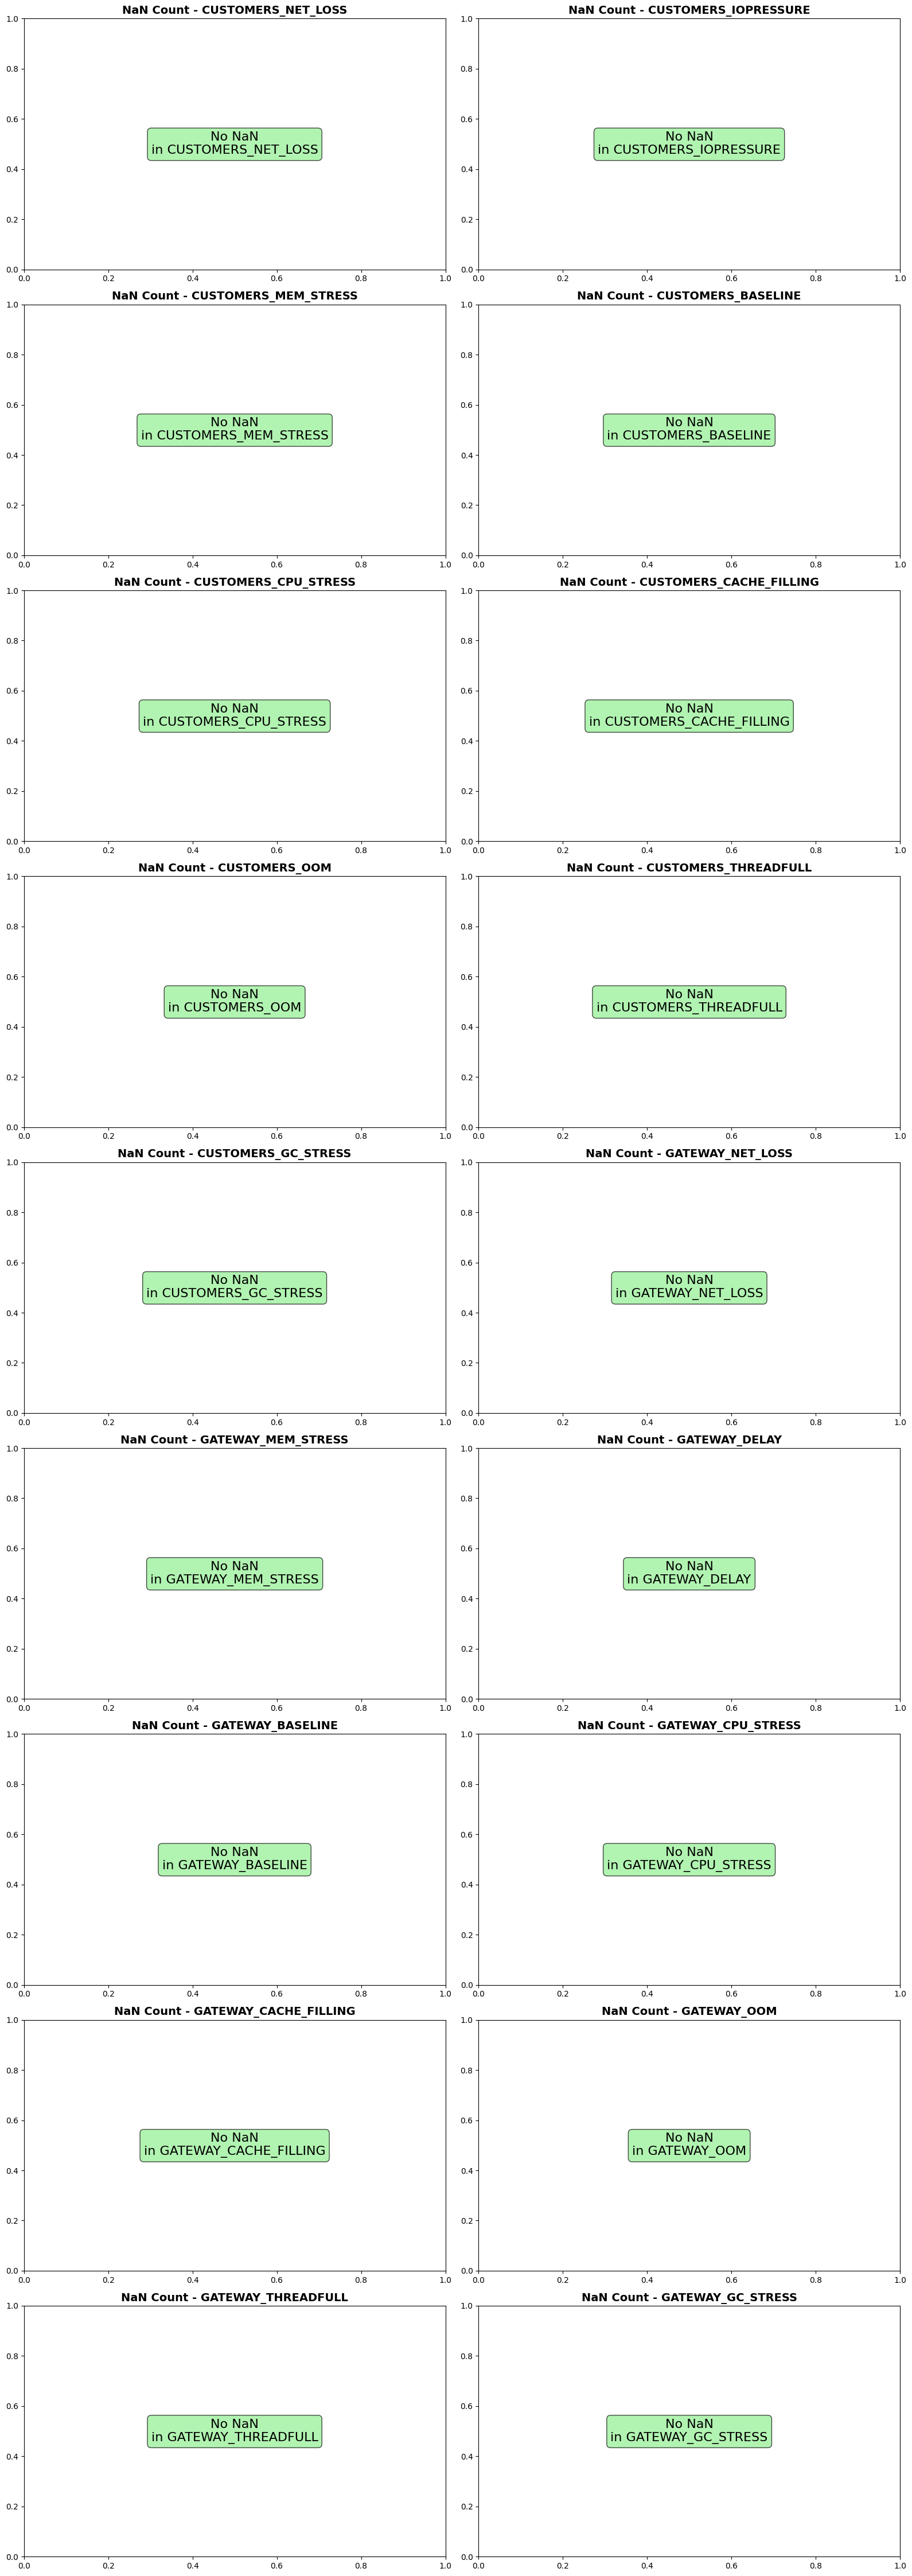


SUMMARY NaN PER ESPERIMENTO
CUSTOMERS_NET_LOSS:      0 NaN totali,   0 features con NaN
CUSTOMERS_IOPRESSURE:      0 NaN totali,   0 features con NaN
CUSTOMERS_MEM_STRESS:      0 NaN totali,   0 features con NaN
CUSTOMERS_BASELINE:      0 NaN totali,   0 features con NaN
CUSTOMERS_CPU_STRESS:      0 NaN totali,   0 features con NaN
CUSTOMERS_CACHE_FILLING:      0 NaN totali,   0 features con NaN
CUSTOMERS_OOM  :      0 NaN totali,   0 features con NaN
CUSTOMERS_THREADFULL:      0 NaN totali,   0 features con NaN
CUSTOMERS_GC_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_NET_LOSS:      0 NaN totali,   0 features con NaN
GATEWAY_MEM_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_DELAY  :      0 NaN totali,   0 features con NaN
GATEWAY_BASELINE:      0 NaN totali,   0 features con NaN
GATEWAY_CPU_STRESS:      0 NaN totali,   0 features con NaN
GATEWAY_CACHE_FILLING:      0 NaN totali,   0 features con NaN
GATEWAY_OOM    :      0 NaN totali,   0 features con NaN
GATEWAY

In [37]:
def plot_simple_nan_histogram(df, title="NaN Count Histogram"):

    nan_counts = df.isnull().sum()
    
    has_nan = nan_counts[nan_counts > 0]
    
    if len(has_nan) == 0:
        print("Nessun valore NaN trovato nel dataset")
        return
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('NaN Count', fontsize=12)
    plt.xticks(range(len(has_nan)), has_nan.index, rotation=45, ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Stampa anche un summary
    print(f"Totale features con NaN: {len(has_nan)}")
    print(f"Totale NaN nel dataset: {has_nan.sum()}")

def plot_nan_distribution_histogram(df, title="NaN Distribution per Row"):
    """
    Plotta la distribuzione del numero di NaN per riga
    """
    # Calcola quanti NaN ci sono per ogni riga
    nan_per_row = df.isnull().sum(axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Istogramma vero e proprio
    plt.hist(nan_per_row, bins=30, color='purple', alpha=0.7, edgecolor='black')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Numero di NaN per riga', fontsize=12)
    plt.ylabel('Frequenza', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Statistiche NaN per riga:")
    print(f"Media: {nan_per_row.mean():.2f}")
    print(f"Mediana: {nan_per_row.median():.2f}")
    print(f"Massimo: {nan_per_row.max()}")
    print(f"Righe senza NaN: {(nan_per_row == 0).sum()}")

def plot_nan_histogram_all_experiments(all_datasets):
    """
    Plotta l'istogramma dei NaN per tutti gli esperimenti
    """
    experiments = list(all_datasets.keys())
    n_experiments = len(experiments)
    
    # Calcola dimensioni griglia
    if n_experiments <= 4:
        rows, cols = 2, 2
        figsize = (16, 10)
    else:
        rows = int(np.ceil(n_experiments / 2))
        cols = 2
        figsize = (16, 5*rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Se c'è solo un subplot, converti in lista
    if n_experiments == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, exp_name in enumerate(experiments):
        if i < len(axes):
            ax = axes[i]
            df = all_datasets[exp_name]
            
            # Calcola NaN count
            nan_counts = df.isnull().sum()
            has_nan = nan_counts[nan_counts > 0]
            
            if len(has_nan) > 0:
                # Plot bar chart
                bars = ax.bar(range(len(has_nan)), has_nan.values, color='red', alpha=0.7)
                
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
                ax.set_xlabel('Features', fontsize=10)
                ax.set_ylabel('NaN Count', fontsize=10)
                
                # Abbrevia i nomi delle features per leggibilità
                feature_names = []
                for name in has_nan.index:
                    if len(name) > 12:
                        # Prendi prime 12 caratteri
                        short_name = name[:12] + "..."
                    else:
                        short_name = name
                    feature_names.append(short_name)
                
                ax.set_xticks(range(len(has_nan)))
                ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
                
                ax.grid(True, alpha=0.3)
                
                # Aggiungi valori sopra le barre se sono poche
                if len(has_nan) <= 8:
                    for bar, value in zip(bars, has_nan.values):
                        ax.text(bar.get_x() + bar.get_width()/2, 
                               bar.get_height() + max(has_nan.values)*0.01,
                               f'{int(value)}', ha='center', va='bottom', fontsize=8)
                
                # Summary testuale nell'angolo
                total_nan = has_nan.sum()
                ax.text(0.02, 0.98, f'Total NaN: {total_nan}', transform=ax.transAxes, 
                       fontsize=10, verticalalignment='top', 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
            else:
                # Nessun NaN trovato
                ax.text(0.5, 0.5, f'No NaN\nin {exp_name.upper()}', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
                ax.set_title(f'NaN Count - {exp_name.upper()}', fontsize=14, fontweight='bold')
    
    # Nascondi subplot vuoti
    for j in range(len(experiments), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary generale
    print(f"\n{'='*60}")
    print("SUMMARY NaN PER ESPERIMENTO")
    print(f"{'='*60}")
    for exp_name, df in cleaned_datasets.items():
        nan_counts = df.isnull().sum()
        has_nan = nan_counts[nan_counts > 0]
        total_nan = has_nan.sum() if len(has_nan) > 0 else 0
        features_with_nan = len(has_nan)
        
        print(f"{exp_name.upper():<15}: {total_nan:>6} NaN totali, {features_with_nan:>3} features con NaN")

# Esempi di utilizzo:

# Tutti gli esperimenti in una dashboard
plot_nan_histogram_all_experiments(cleaned_datasets)


## Experiments plots

/tmp/ipykernel_58971/3487596775.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True,
/tmp/ipykernel_58971/3487596775.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


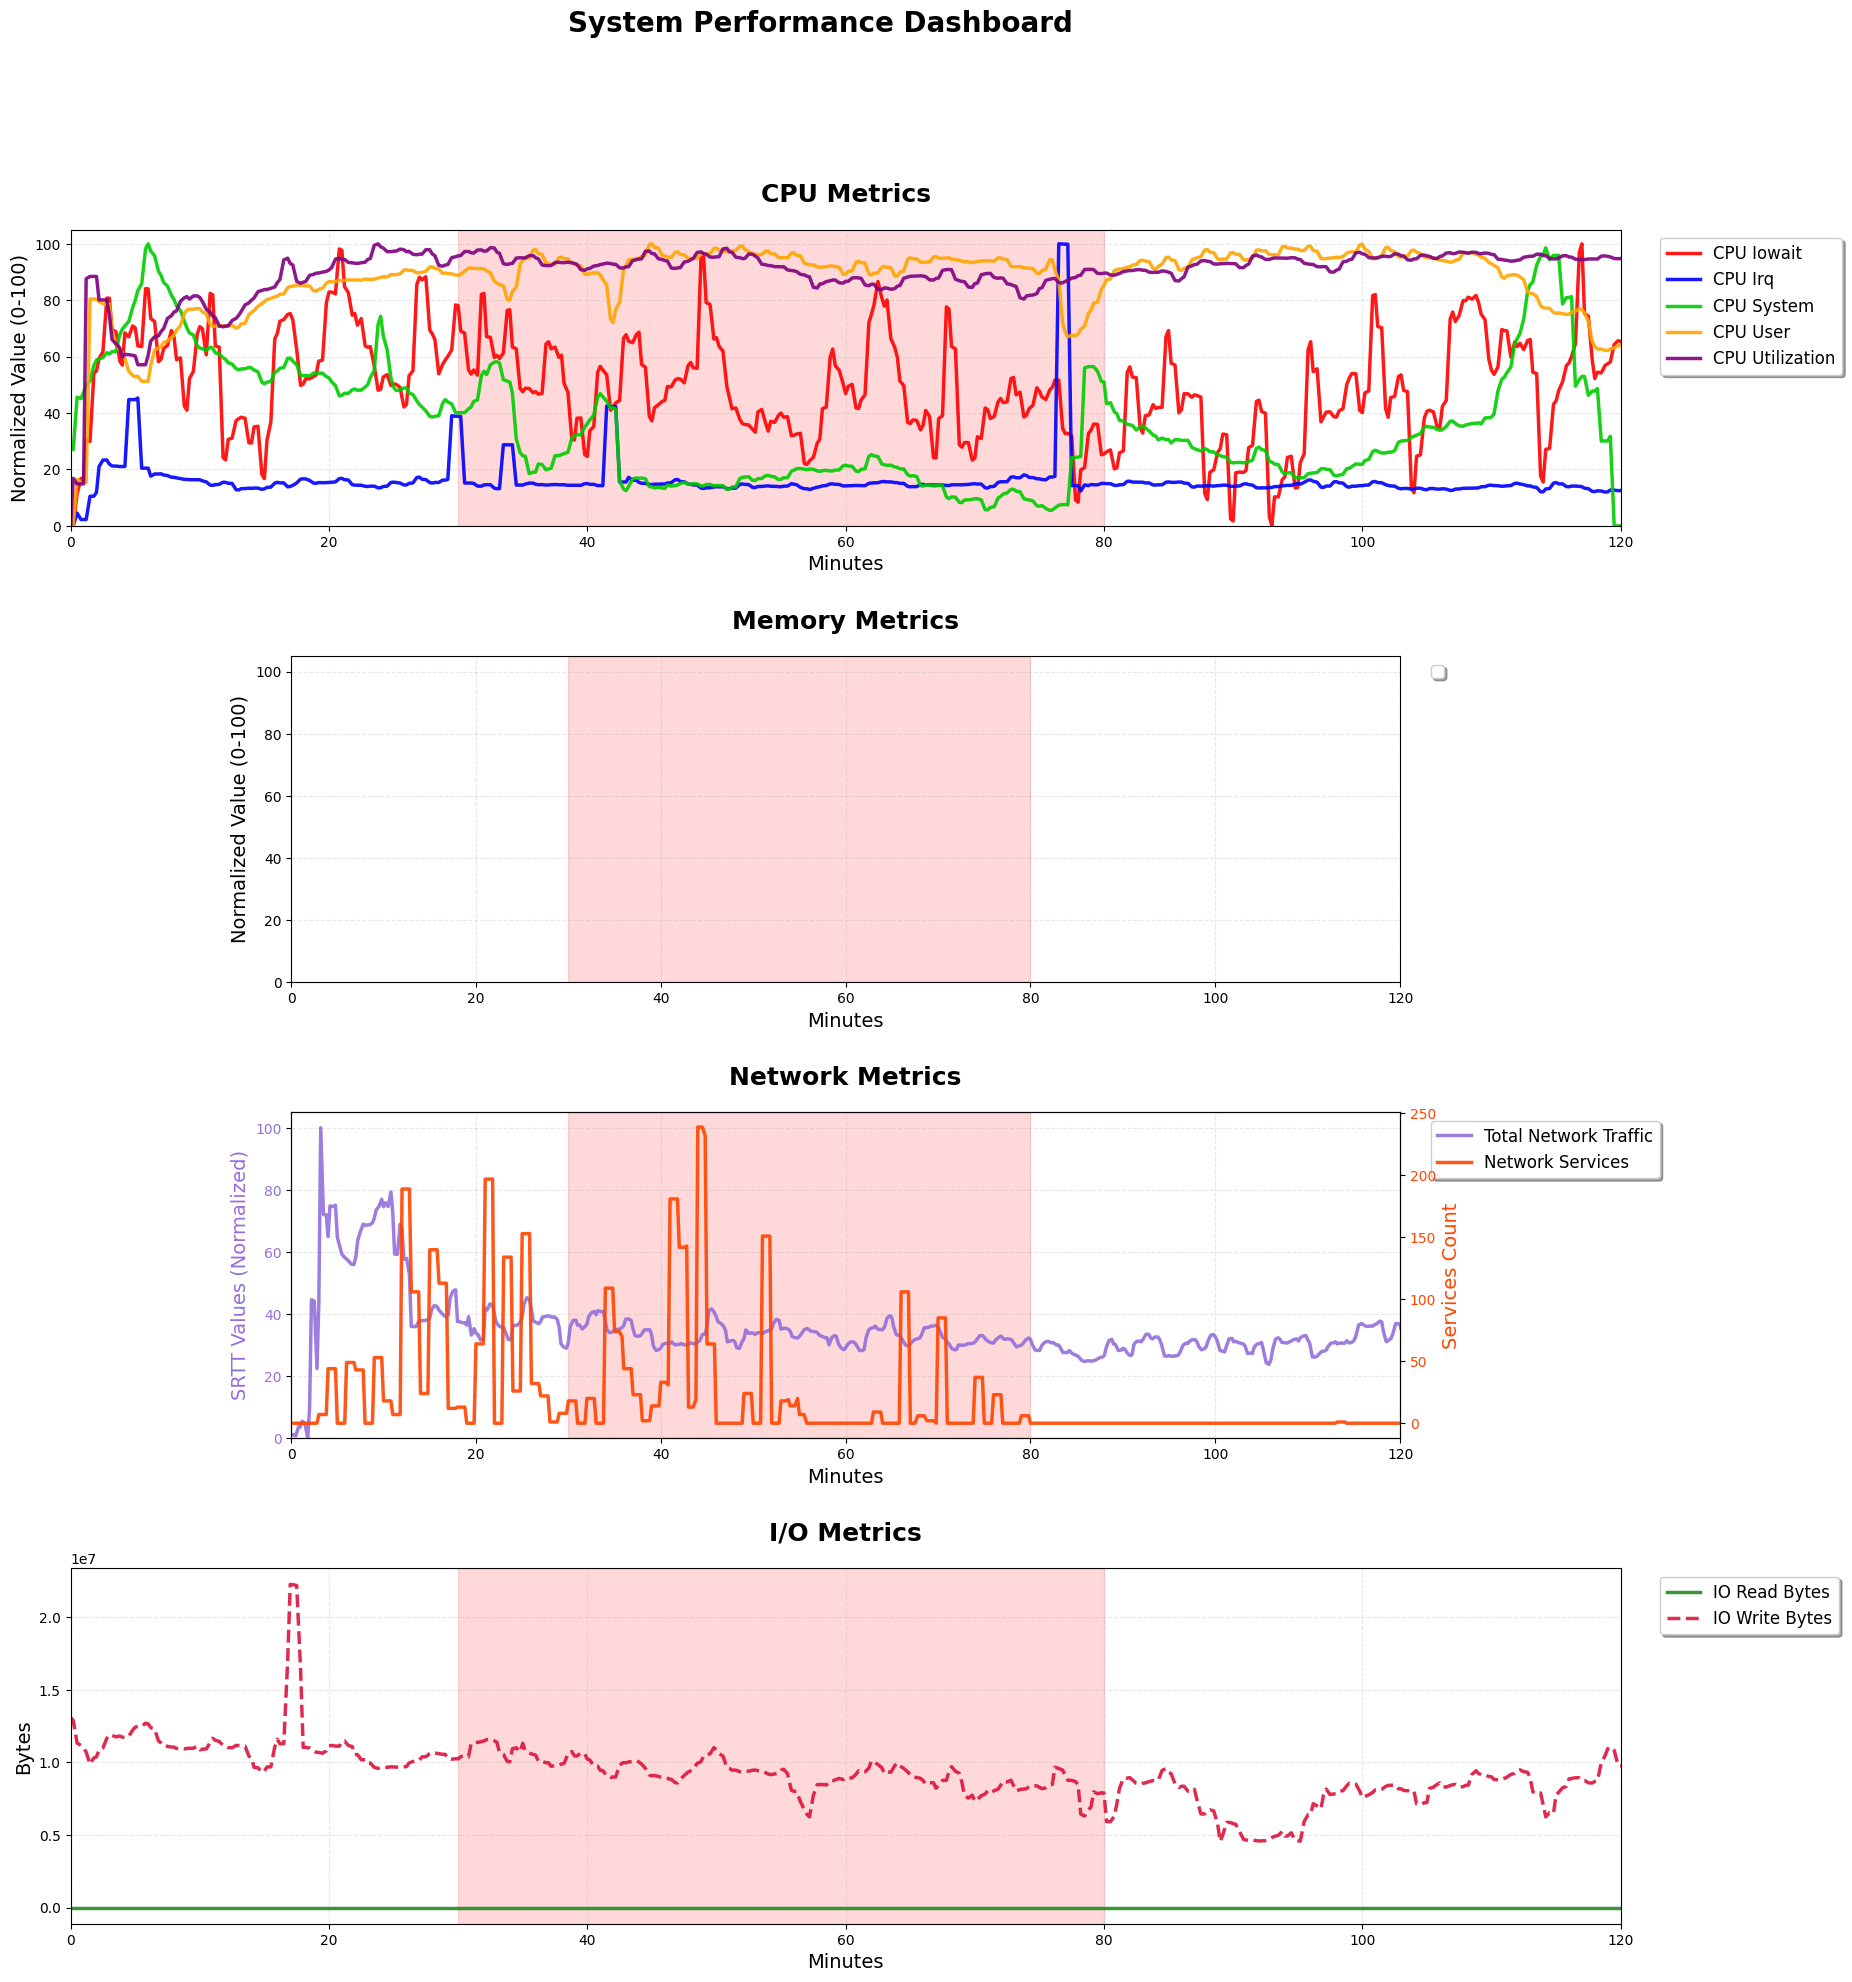

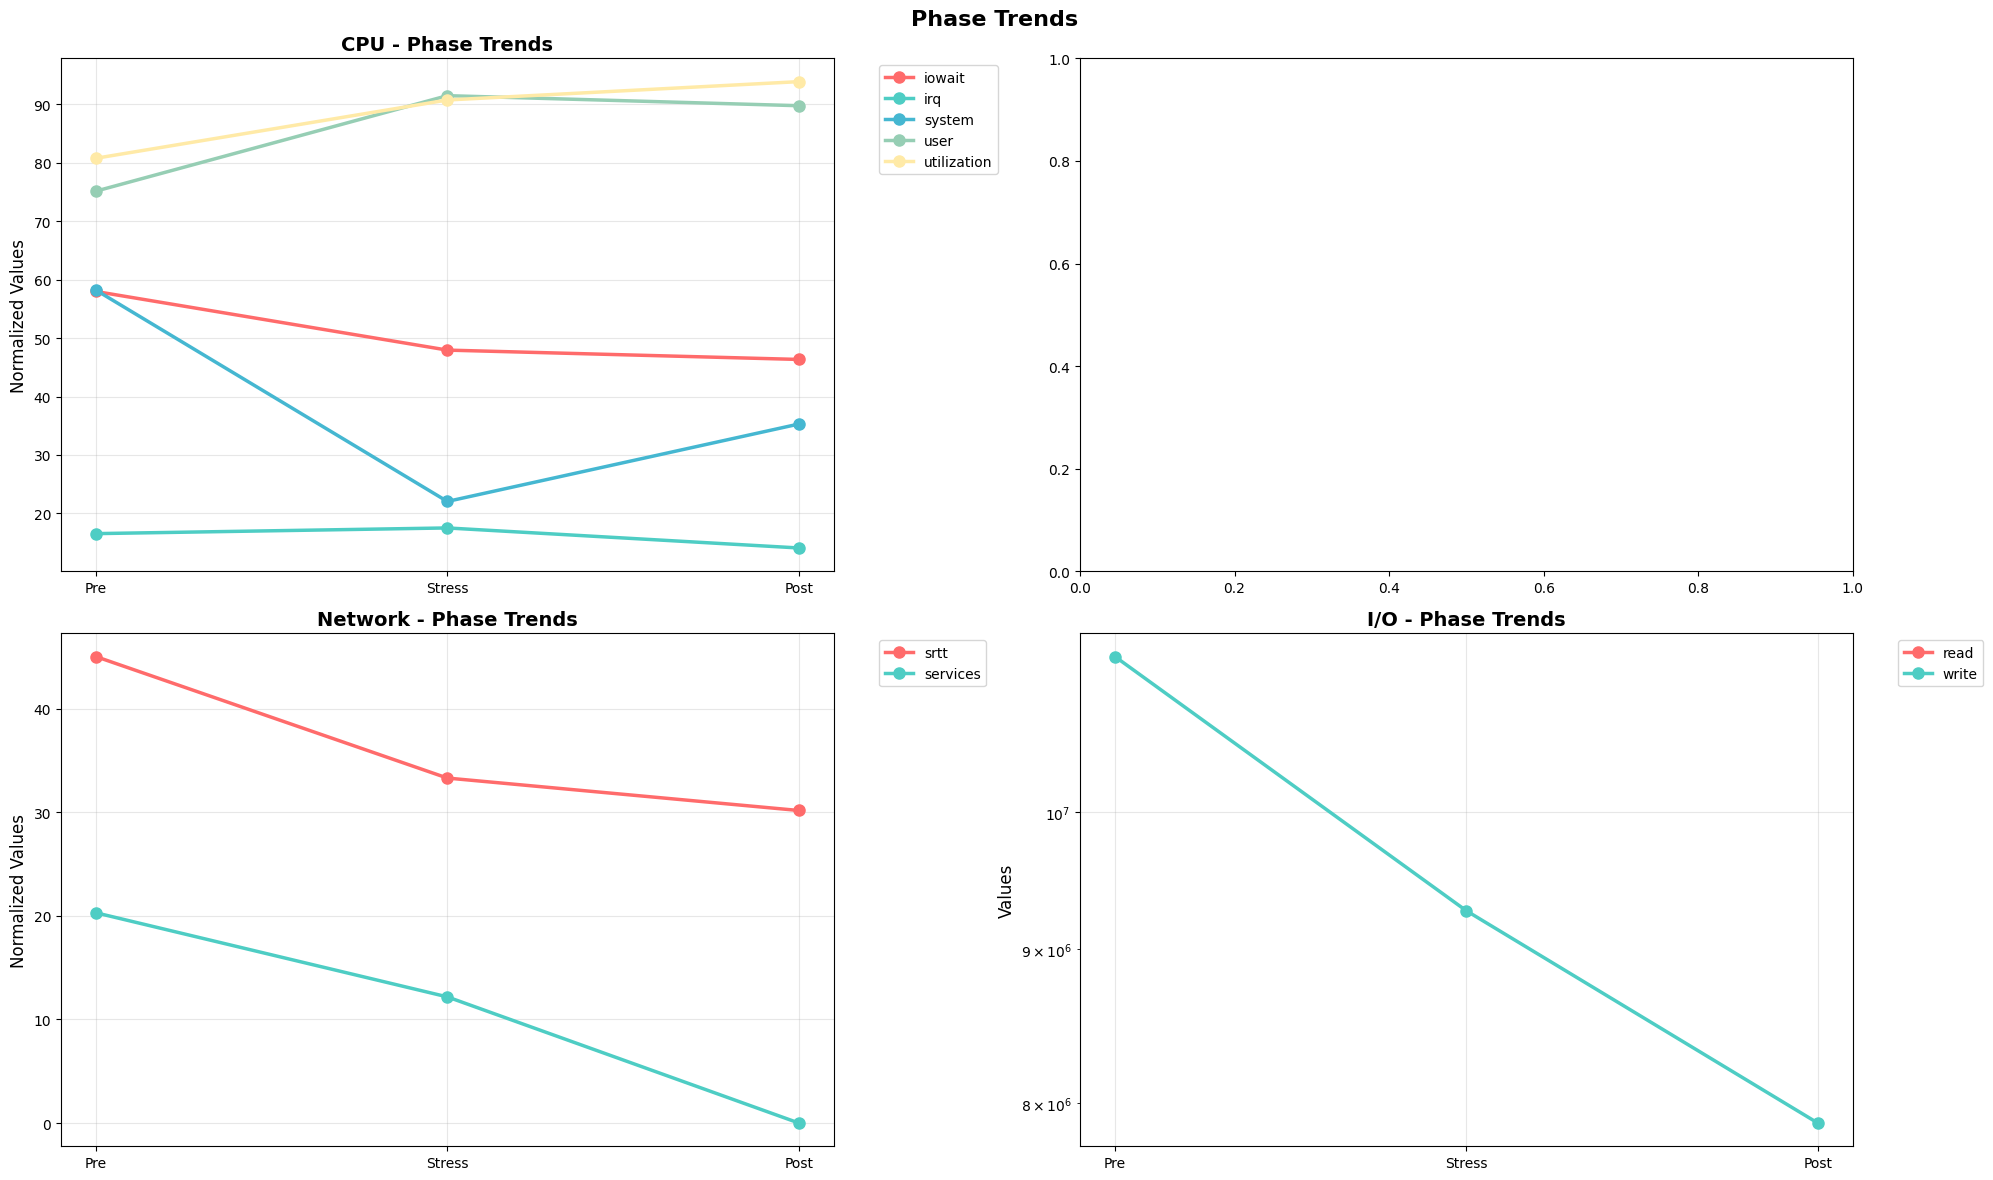

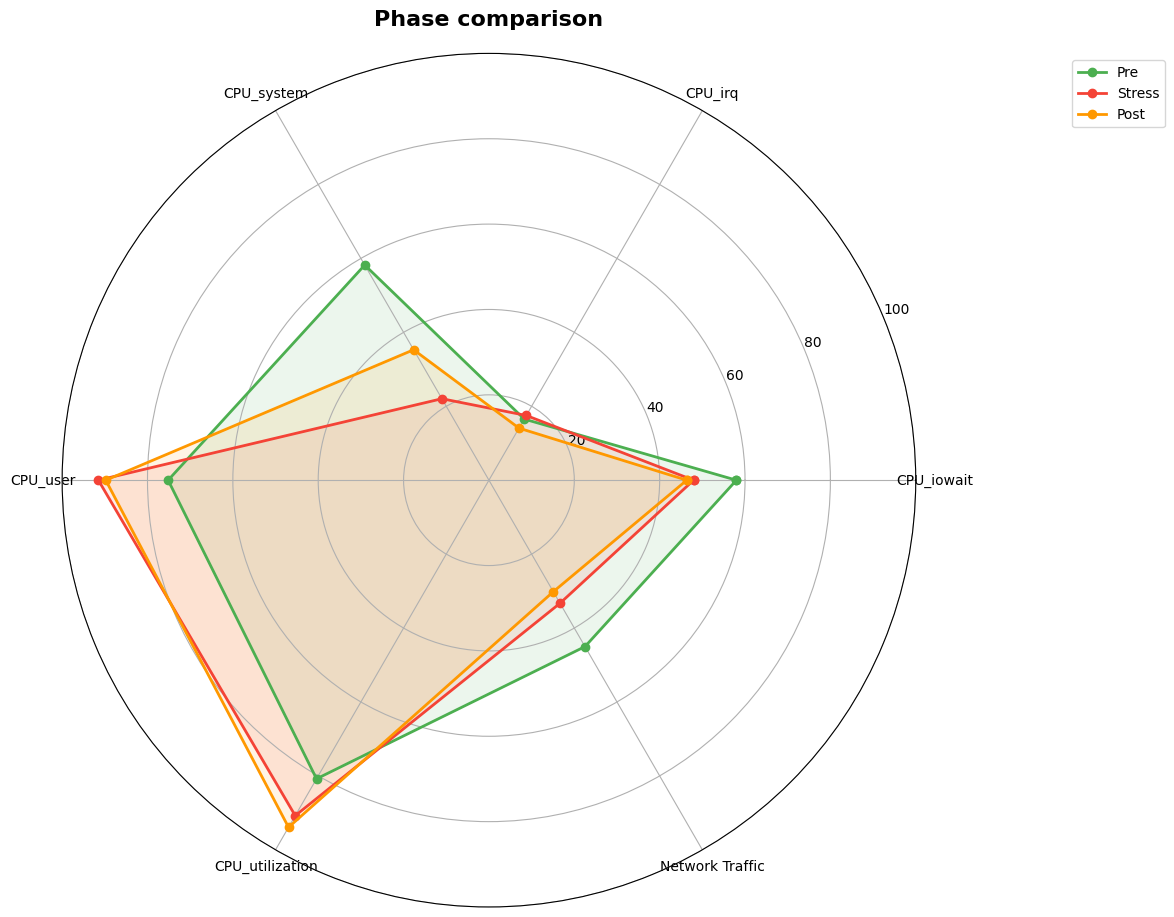

In [20]:
def normalize_0_100(series: pd.Series) -> pd.Series:
    min_val = series.min()
    max_val = series.max()
    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        return pd.Series([0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val) * 100

def get_cpu_metrics(df):
    metrics = {}
    cpu_types = ['iowait', 'irq', 'system', 'user', 'utilization']
    
    for cpu_type in cpu_types:
        cols = [col for col in df.columns if cpu_type.lower() in col.lower() 
                and 'cpu' in col.lower() and 'minutes' not in col.lower() 
                and pd.api.types.is_numeric_dtype(df[col])]
        if cols:
            metrics[cpu_type] = df[cols].sum(axis=1)
    return metrics

def get_memory_metrics(df):
    metrics = {}
    mem_types = ['memavailable', 'memutil', 'memcache']
    
    for mem_type in mem_types:
        cols = [col for col in df.columns if mem_type in col.lower() 
                and 'minutes' not in col.lower() 
                and pd.api.types.is_numeric_dtype(df[col])]
        if cols:
            metrics[mem_type.replace('mem', '')] = df[cols[0]]
    return metrics

def get_network_metrics(df):
    metrics = {}
    
    # SRTT traffic
    srtt_cols = [col for col in df.columns if 'srtt' in col.lower() 
                 and 'minutes' not in col.lower() 
                 and pd.api.types.is_numeric_dtype(df[col])]
    if srtt_cols:
        metrics['srtt'] = df[srtt_cols].sum(axis=1)
    
    # Service metrics
    service_cols = [col for col in df.columns 
                    if any(term in col.lower() for term in ['api', 'service', 'gateway', 'customer', 'vet', 'visit'])
                    and 'srtt' not in col.lower() 
                    and 'minutes' not in col.lower()
                    and pd.api.types.is_numeric_dtype(df[col])]
    if service_cols:
        metrics['services'] = df[service_cols].sum(axis=1)
    
    return metrics

def get_io_metrics(df):
    metrics = {}
    
    read_cols = [col for col in df.columns if 'readbytes' in col.lower() 
                 and 'minutes' not in col.lower() 
                 and pd.api.types.is_numeric_dtype(df[col])]
    if read_cols:
        metrics['read'] = df[read_cols].sum(axis=1)
    
    write_cols = [col for col in df.columns if 'writebytes' in col.lower() 
                  and 'minutes' not in col.lower() 
                  and pd.api.types.is_numeric_dtype(df[col])]
    if write_cols:
        metrics['write'] = df[write_cols].sum(axis=1)
    
    return metrics

def plot_enhanced_dashboard(df, time_col='minutes', normalize=True, style='seaborn'):
    plt.style.use(style if style in plt.style.available else 'default')
    
    fig = plt.figure(figsize=(20, 22))
    gs = fig.add_gridspec(4, 5, height_ratios=[1, 1.1, 1.1, 1.2], width_ratios=[0.5, 1, 1, 1, 0.5],
                          hspace=0.4, wspace=0.2)
    
    # Color schemes con colori più distinti
    cpu_colors = ['#FF0000', '#0000FF', '#00CC00', '#FFA500', '#800080']  # Rosso, Blu, Verde, Arancione, Viola
    mem_colors = ['#1E90FF', '#32CD32', '#FFD700']  # Blu cielo, Verde lime, Oro
    net_colors = ['#9370DB', '#FF4500']  # Viola medio, Rosso-arancione
    io_colors = ['#228B22', '#DC143C']  # Verde foresta, Cremisi
    
    # Stili di linea distinti
    line_styles = ['-', '--', '-.', ':', '-']
    
    # CPU Plot (prima riga - spanning tutte le 5 colonne)
    ax1 = fig.add_subplot(gs[0, :])
    cpu_metrics = get_cpu_metrics(df)
    
    ax1.axvspan(30, 80, alpha=0.15, color='red', zorder=0)
    
    for i, (metric, series) in enumerate(cpu_metrics.items()):
        if normalize:
            series = normalize_0_100(series)
        ax1.plot(df[time_col], series, label=f'CPU {metric.title()}', 
                color=cpu_colors[i % len(cpu_colors)], 
                linewidth=2.5, alpha=0.9)
    
    ax1.set_title('CPU Metrics', fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Minutes', fontsize=14)
    ax1.set_ylabel('Normalized Value (0-100)' if normalize else 'Value', fontsize=14)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, 
               fancybox=True, shadow=True, fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(0, 120)
    if normalize:
        ax1.set_ylim(0, 105)
    
    ax2 = fig.add_subplot(gs[1, 1:4])
    mem_metrics = get_memory_metrics(df)
    
    ax2.axvspan(30, 80, alpha=0.15, color='red', zorder=0)
    
    for i, (metric, series) in enumerate(mem_metrics.items()):
        if normalize:
            series = normalize_0_100(series)
        ax2.plot(df[time_col], series, label=f'Memory {metric.title()}', 
                color=mem_colors[i % len(mem_colors)], 
                linewidth=2.5, alpha=0.9)
    
    ax2.set_title('Memory Metrics', fontsize=18, fontweight='bold', pad=20)
    ax2.set_xlabel('Minutes', fontsize=14)
    ax2.set_ylabel('Normalized Value (0-100)' if normalize else 'Value', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, 
               fancybox=True, shadow=True, fontsize=12)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim(0, 120)
    if normalize:
        ax2.set_ylim(0, 105)
    
    ax3 = fig.add_subplot(gs[2, 1:4])
    net_metrics = get_network_metrics(df)
    
    ax3.axvspan(30, 80, alpha=0.15, color='red', zorder=0)
    
    if 'srtt' in net_metrics:
        srtt_data = net_metrics['srtt']
        if normalize:
            srtt_data = normalize_0_100(srtt_data)
        line1 = ax3.plot(df[time_col], srtt_data, color='#9370DB', linewidth=2.5, 
                        label='Total Network Traffic', alpha=0.9)
        ax3.set_ylabel('SRTT Values (Normalized)' if normalize else 'SRTT Values', 
                      color='#9370DB', fontsize=14)
        ax3.tick_params(axis='y', labelcolor='#9370DB')
    
    ax3_right = None
    if 'services' in net_metrics:
        services_data = net_metrics['services']
        ax3_right = ax3.twinx()
        line2 = ax3_right.plot(df[time_col], services_data, color='#FF4500', 
                              linewidth=2.5, label='Network Services', alpha=0.9)
        ax3_right.set_ylabel('Services Count', color='#FF4500', fontsize=14)
        ax3_right.tick_params(axis='y', labelcolor='#FF4500')
    
    ax3.set_title('Network Metrics', fontsize=18, fontweight='bold', pad=20)
    ax3.set_xlabel('Minutes', fontsize=14)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xlim(0, 120)
    if normalize and 'srtt' in net_metrics:
        ax3.set_ylim(0, 105)
    
    # Legenda combinata per network
    lines, labels = [], []
    if 'srtt' in net_metrics:
        lines.extend(ax3.get_lines())
        labels.append('Total Network Traffic')
    if ax3_right is not None:
        lines.extend(ax3_right.get_lines()) 
        labels.append('Network Services')
    
    if lines:
        ax3.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc='upper left', 
                  frameon=True, fancybox=True, shadow=True, fontsize=12)
    
    ax4 = fig.add_subplot(gs[3, :])
    io_metrics = get_io_metrics(df)
    
    ax4.axvspan(30, 80, alpha=0.15, color='red', zorder=0)
    
    for i, (metric, series) in enumerate(io_metrics.items()):
        ax4.plot(df[time_col], series, label=f'IO {metric.title()} Bytes', 
                color=io_colors[i % len(io_colors)], 
                linestyle=line_styles[i % len(line_styles)],
                linewidth=2.5, alpha=0.9)
    
    ax4.set_title('I/O Metrics', fontsize=18, fontweight='bold', pad=20)
    ax4.set_xlabel('Minutes', fontsize=14)
    ax4.set_ylabel('Bytes', fontsize=14)  # Sempre "Bytes" per I/O
    ax4.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, 
               fancybox=True, shadow=True, fontsize=12)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_xlim(0, 120)
    
    plt.suptitle(f'System Performance Dashboard', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()

def plot_phase_means_line(df, time_col='minutes'):
    """
    Opzione 2: Line plot delle medie per fase
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    metric_groups = [
        ('CPU', get_cpu_metrics(df)),
        ('Memory', get_memory_metrics(df)),
        ('Network', get_network_metrics(df)),
        ('I/O', get_io_metrics(df))
    ]
    
    phases = ['Pre', 'Stress', 'Post']
    phase_masks = {
        'Pre': df[df[time_col] < 30].index,
        'Stress': df[(df[time_col] >= 30) & (df[time_col] <= 80)].index,
        'Post': df[df[time_col] > 80].index
    }
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for idx, (group_name, metrics) in enumerate(metric_groups):
        if not metrics or idx >= len(axes):
            continue
            
        ax = axes[idx]
        
        for i, (metric_name, series) in enumerate(metrics.items()):
            phase_means = []
            for phase in phases:
                mask = phase_masks[phase]
                if group_name == 'I/O':
                    # Per I/O usa valori originali
                    mean_val = series[mask].mean()
                else:
                    # Normalizza per altri gruppi
                    norm_series = normalize_0_100(series)
                    mean_val = norm_series[mask].mean()
                phase_means.append(mean_val)
            
            ax.plot(phases, phase_means, marker='o', linewidth=2.5, 
                   label=metric_name, color=colors[i % len(colors)], markersize=8)
        
        ax.set_ylabel('Values' if group_name == 'I/O' else 'Normalized Values', fontsize=12)
        ax.set_title(f'{group_name} - Phase Trends', fontsize=14, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        if group_name == 'I/O':
            ax.set_yscale('log')
    
    plt.suptitle('Phase Trends', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_phase_radar(df, time_col='minutes'):
    """
    Opzione 4: Radar chart per fase
    """
    phases = {
        'Pre': df[df[time_col] < 30],
        'Stress': df[(df[time_col] >= 30) & (df[time_col] <= 80)],
        'Post': df[df[time_col] > 80]
    }
    
    all_metrics = {}
    cpu_metrics = get_cpu_metrics(df)
    mem_metrics = get_memory_metrics(df)
    net_metrics = get_network_metrics(df)
    
    for k, v in cpu_metrics.items():
        all_metrics[f'CPU_{k}'] = normalize_0_100(v)
    for k, v in mem_metrics.items():
        all_metrics[f'MEM_{k}'] = normalize_0_100(v)
    for k, v in net_metrics.items():
        if k == 'srtt':  # Solo SRTT normalizzato
            all_metrics['Network Traffic'] = normalize_0_100(v)
    
    metric_names = list(all_metrics.keys())
    n_metrics = len(metric_names)
    
    if n_metrics == 0:
        print("Nessuna metrica disponibile per radar chart")
        return
    
    # Calcola angoli per radar
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Chiude il cerchio
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    colors = ['#4CAF50', '#F44336', '#FF9800']
    phase_names = ['Pre', 'Stress', 'Post']
    
    for i, (phase_name, phase_df) in enumerate(phases.items()):
        values = []
        for metric_name in metric_names:
            series = all_metrics[metric_name]
            mean_val = series[phase_df.index].mean()
            values.append(mean_val)
        
        values += values[:1]  # Chiude il cerchio
        
        ax.plot(angles, values, 'o-', linewidth=2, label=phase_name, 
               color=colors[i], markersize=6)
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Configurazione radar
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names, fontsize=10)
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'])
    ax.grid(True)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title('Phase comparison', size=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Usage examples:
EXPERIMENT_NAME = 'gateway_baseline'

plot_enhanced_dashboard(cleaned_datasets[EXPERIMENT_NAME])
plot_phase_means_line(cleaned_datasets[EXPERIMENT_NAME])
plot_phase_radar(cleaned_datasets[EXPERIMENT_NAME])

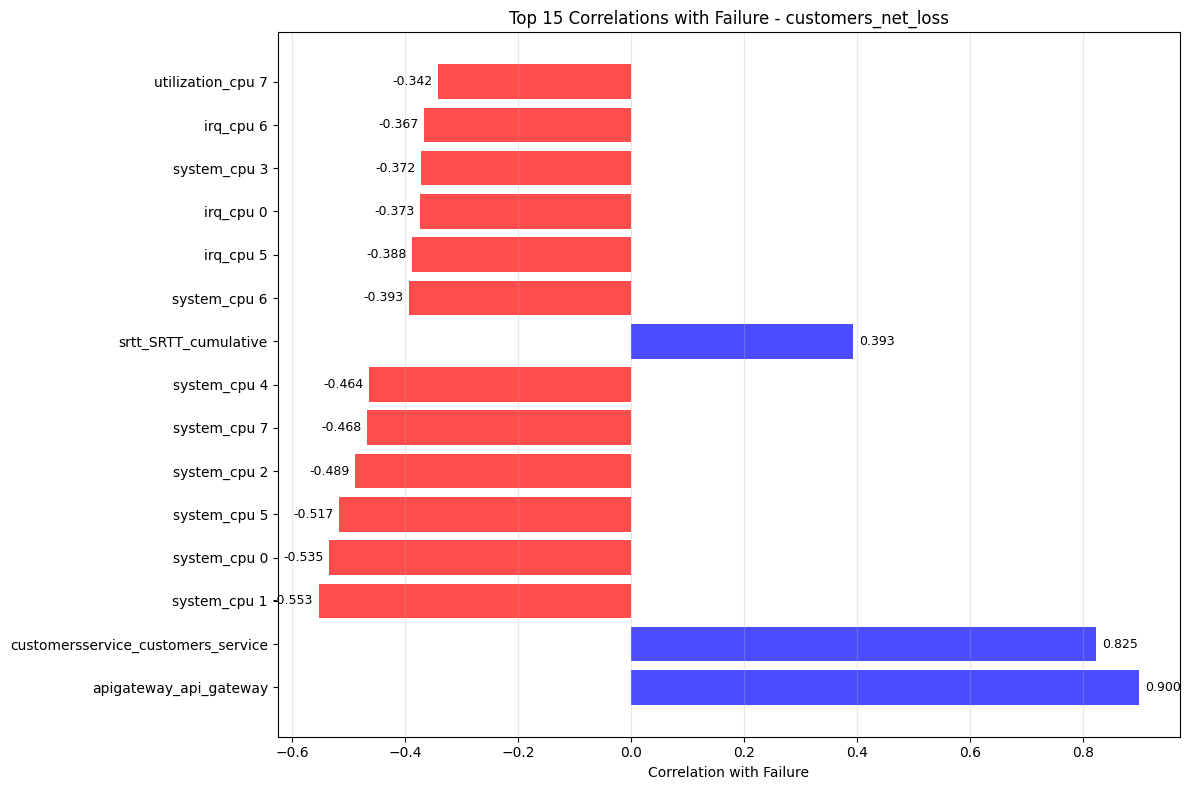

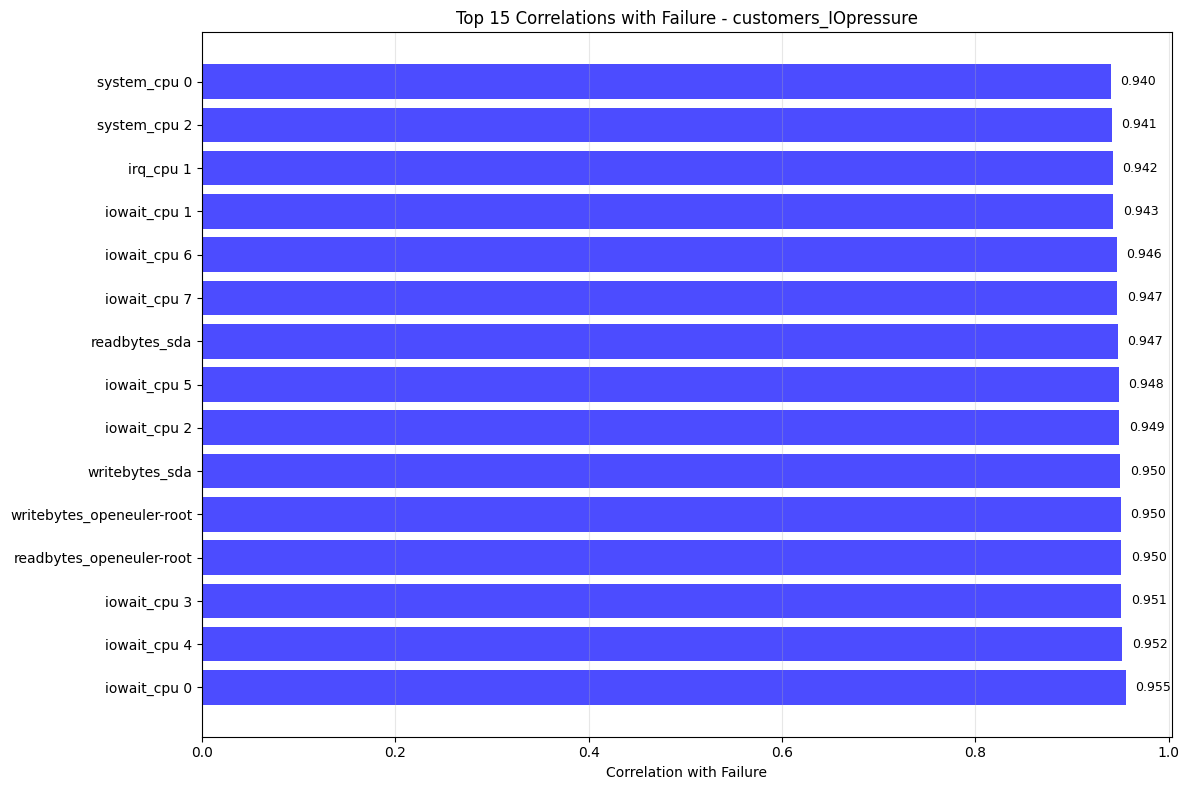

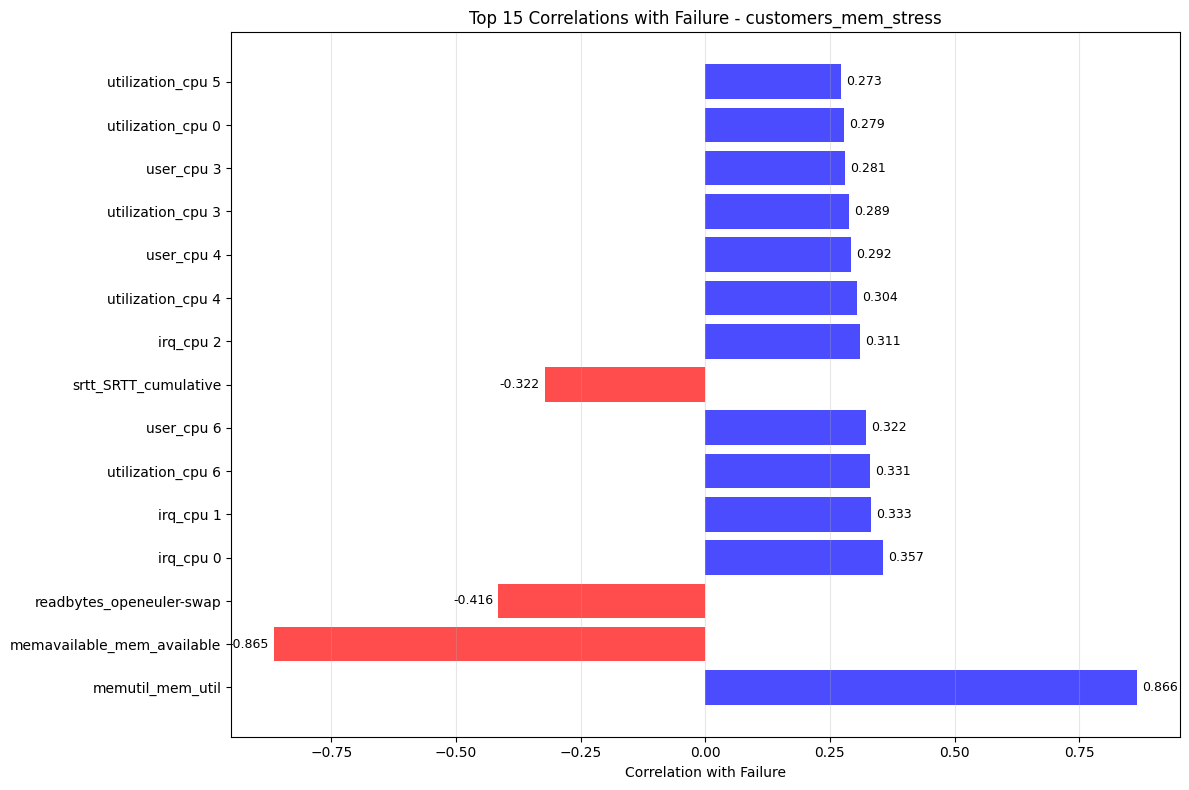

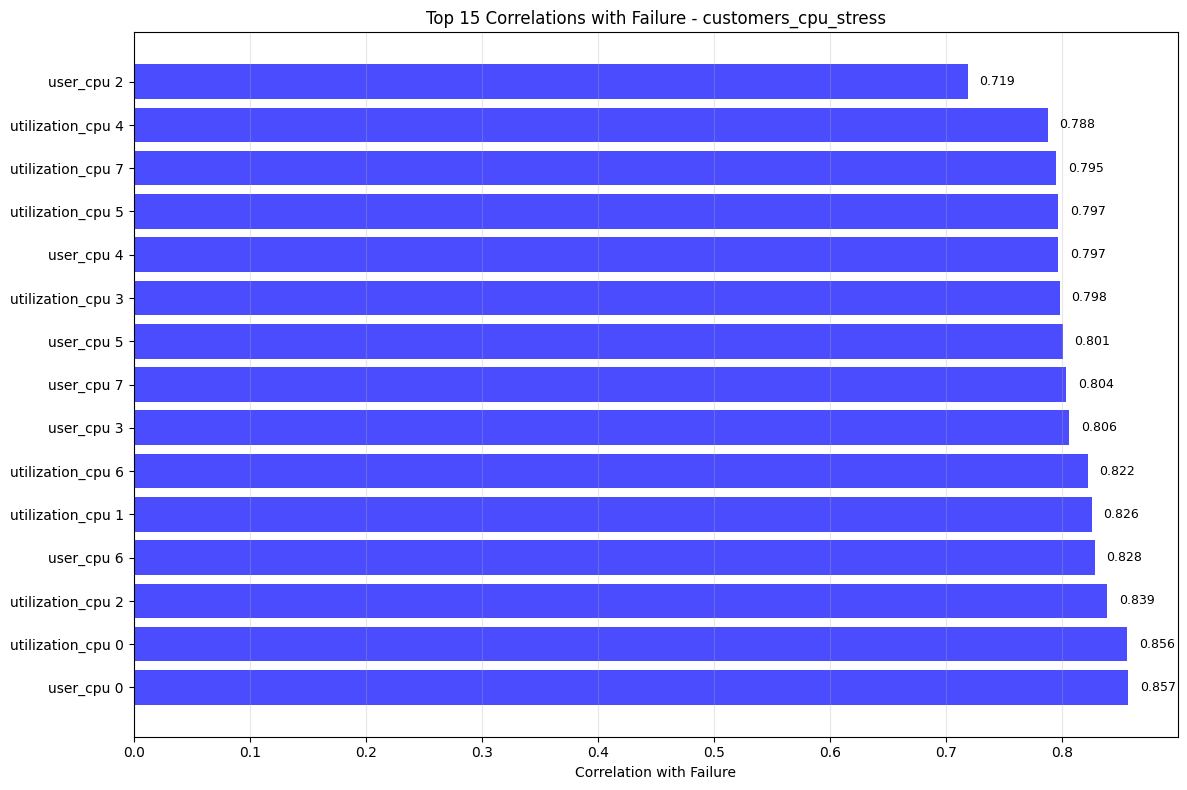

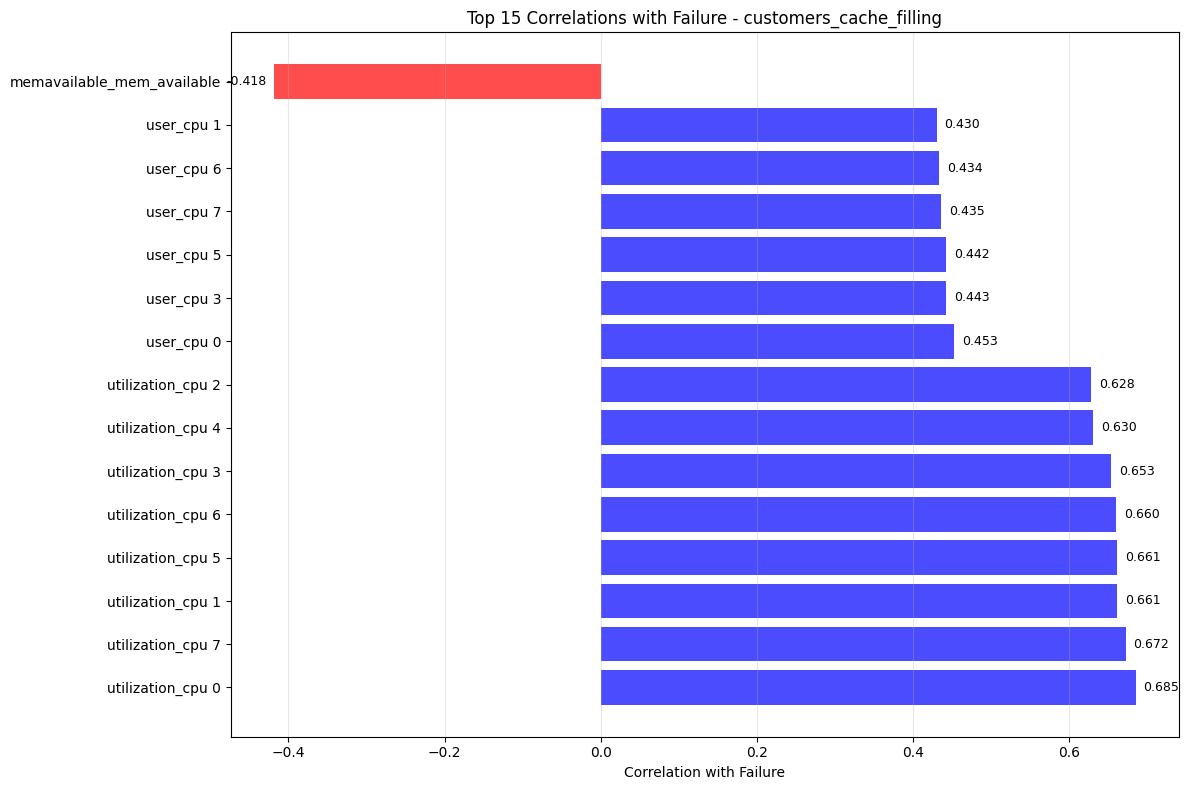

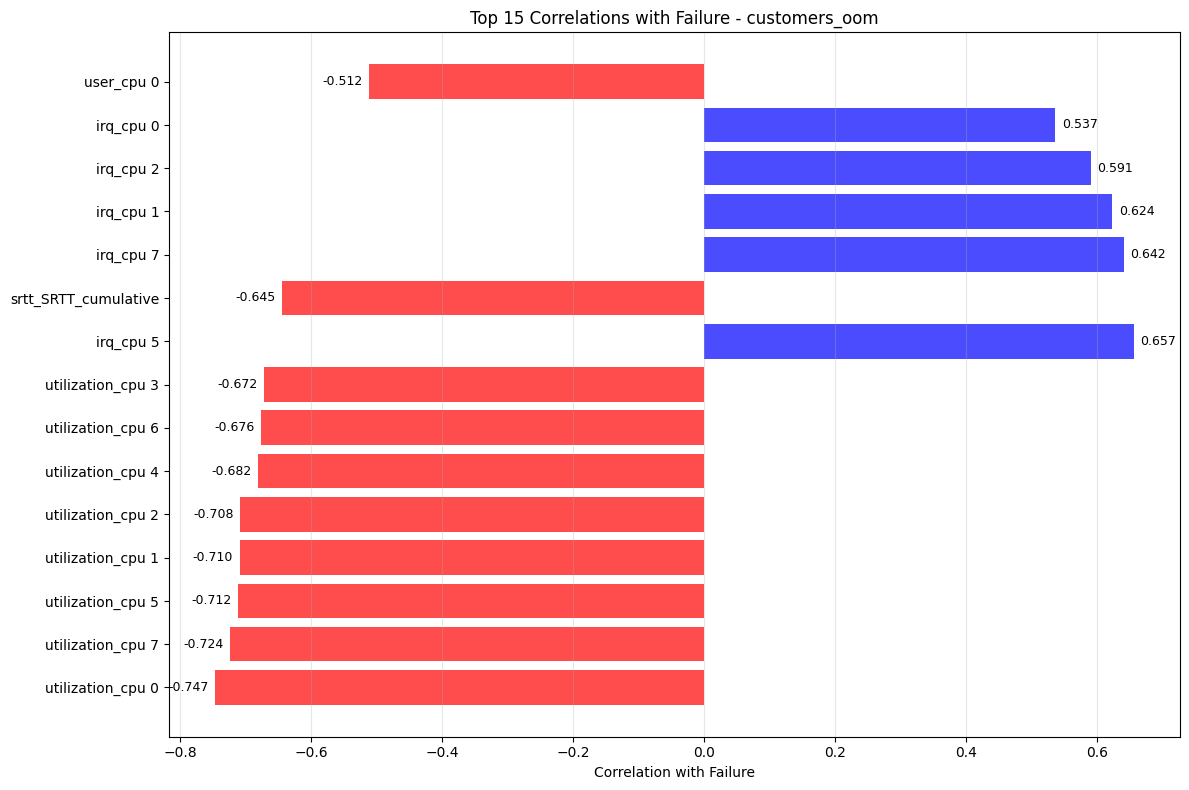

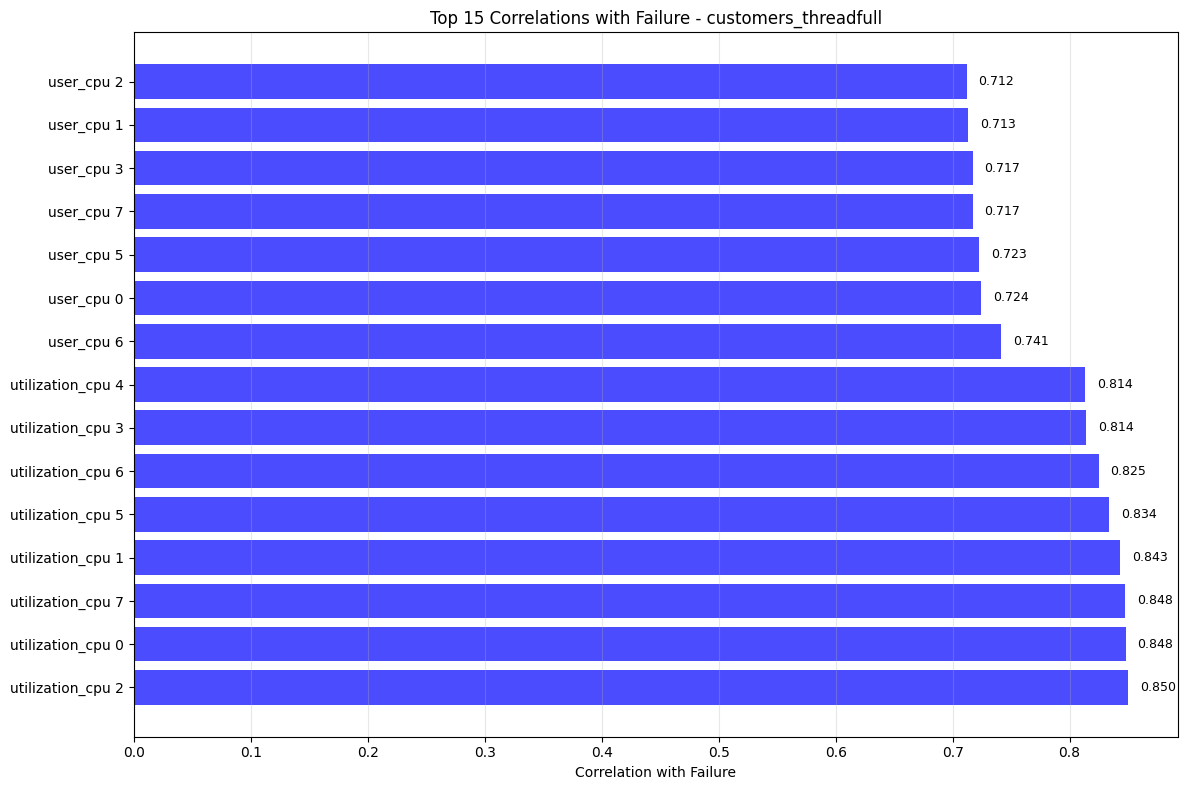

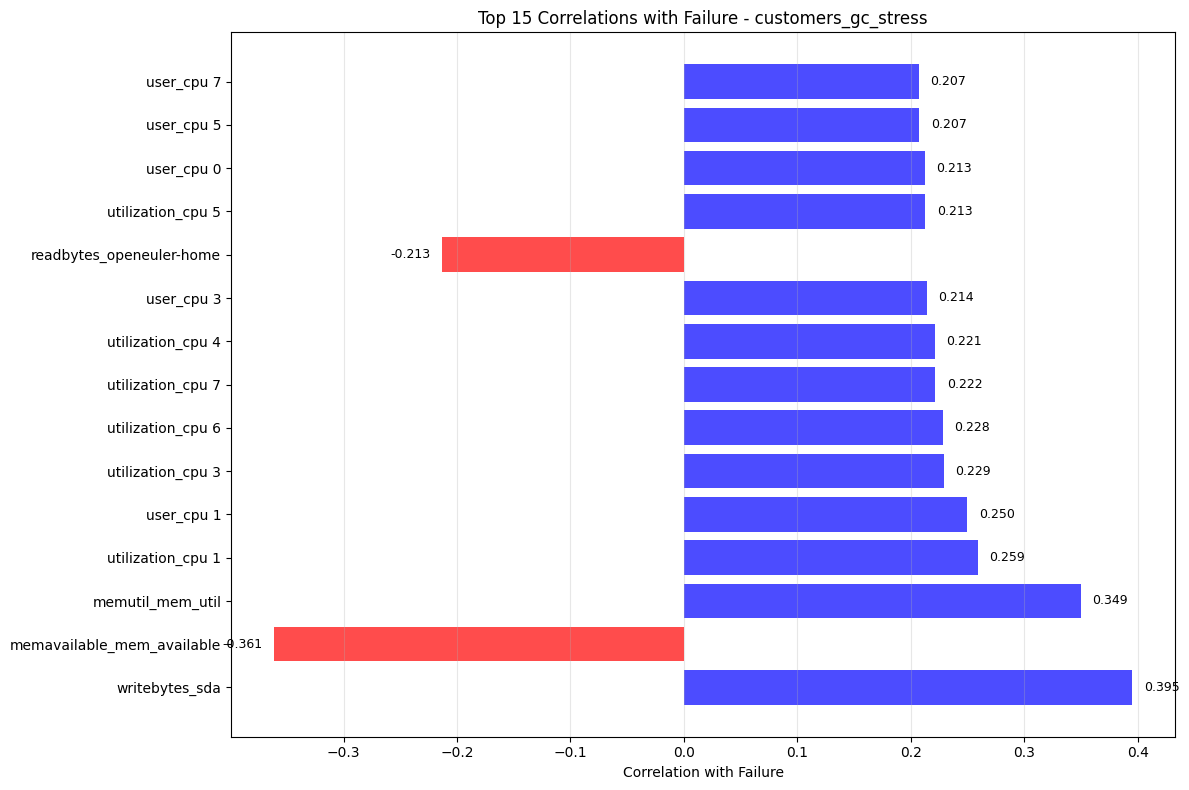

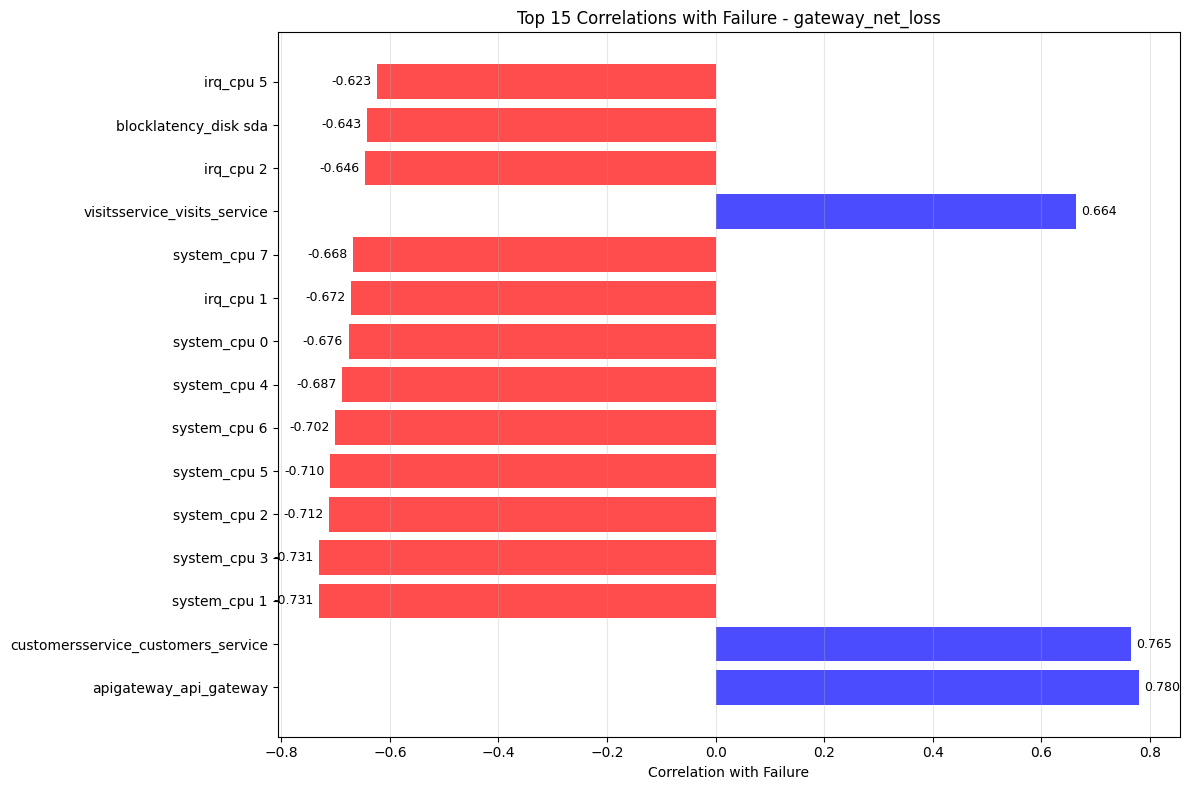

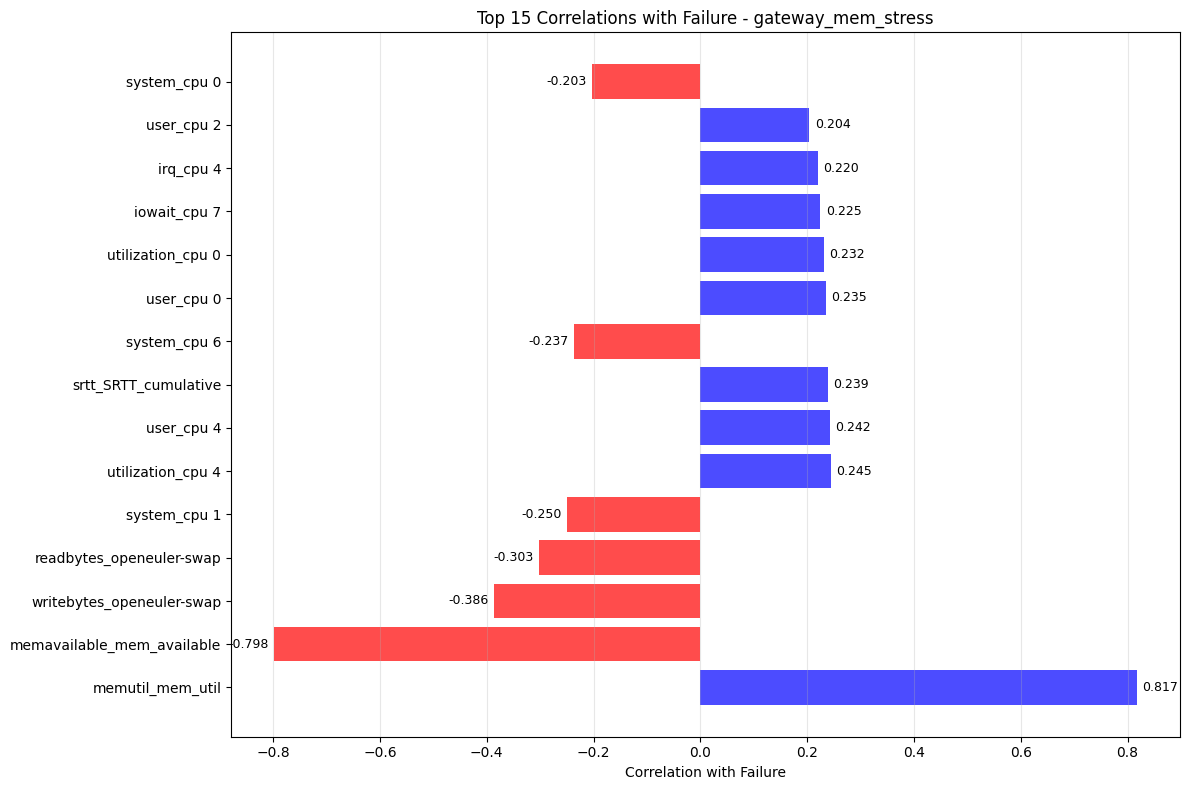

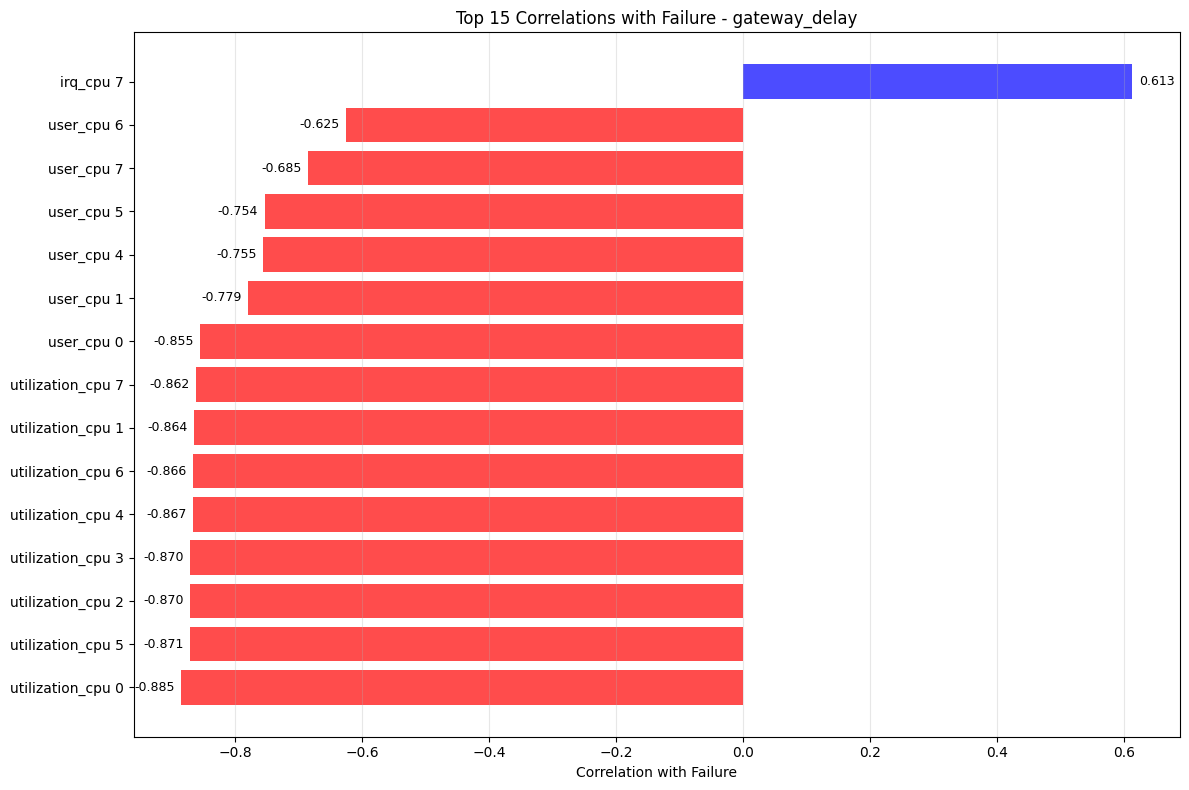

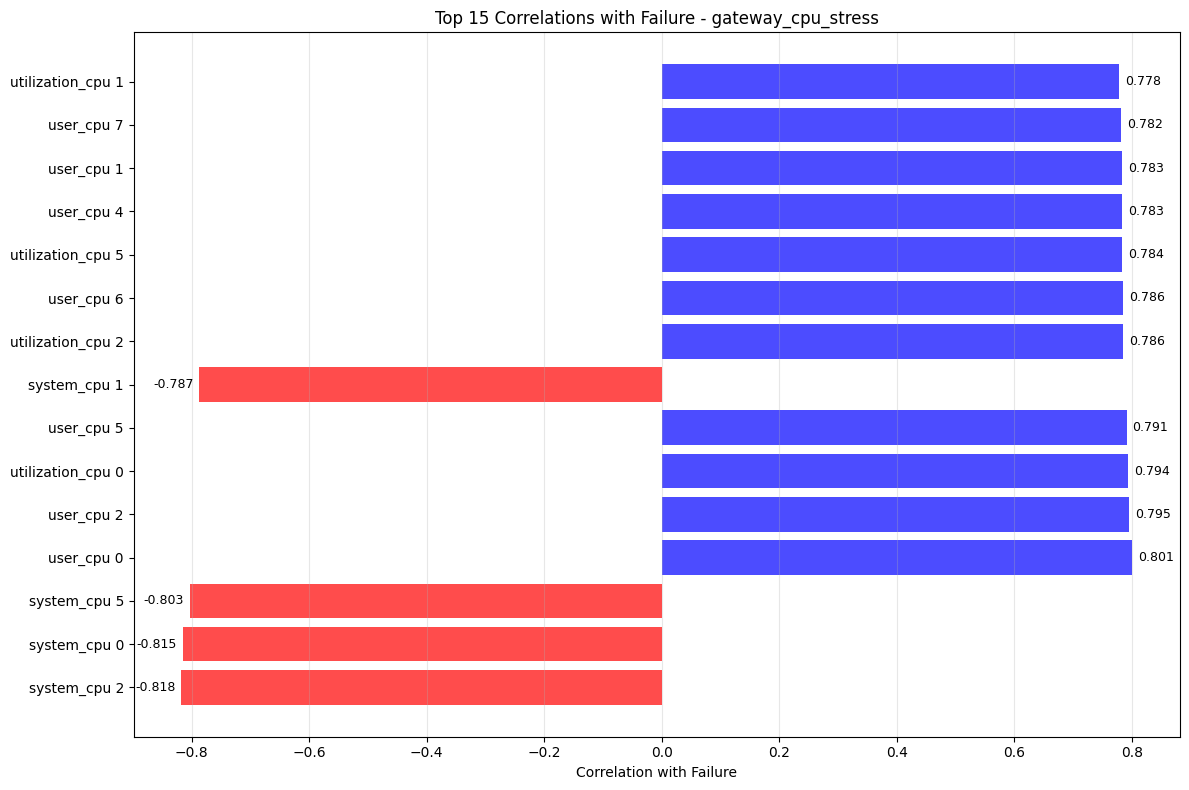

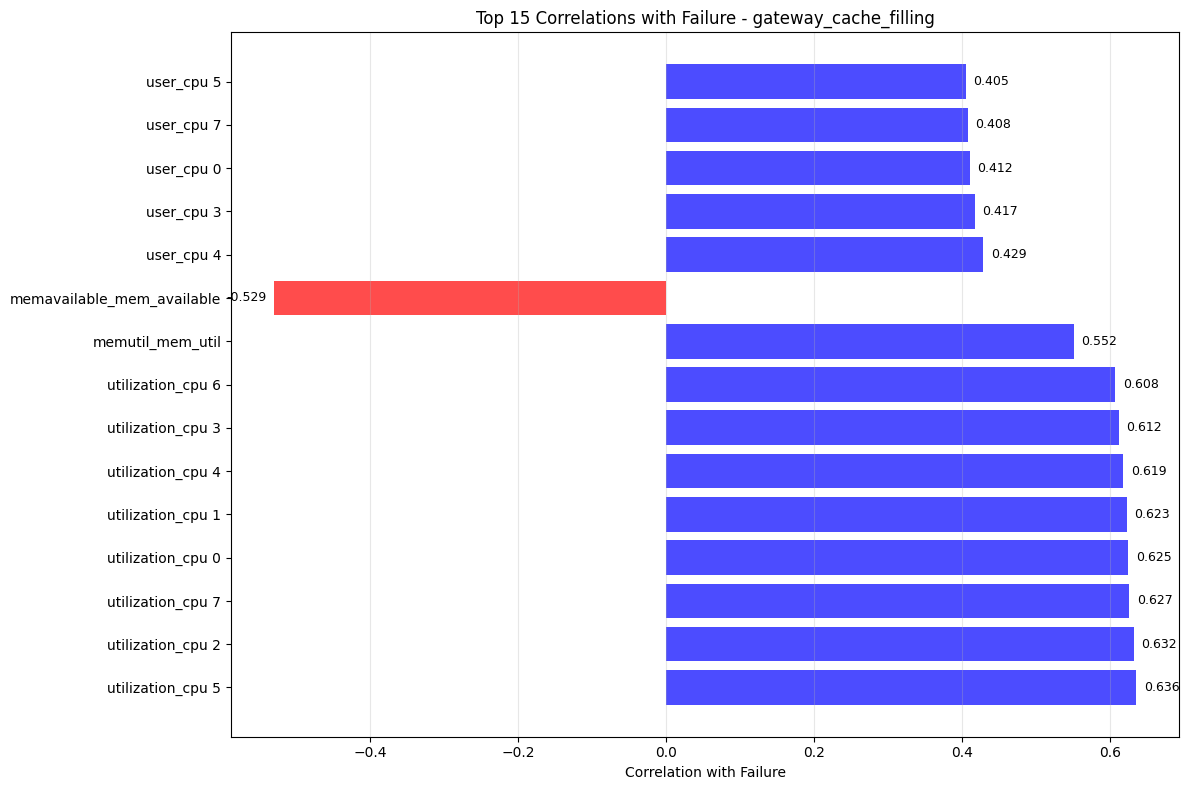

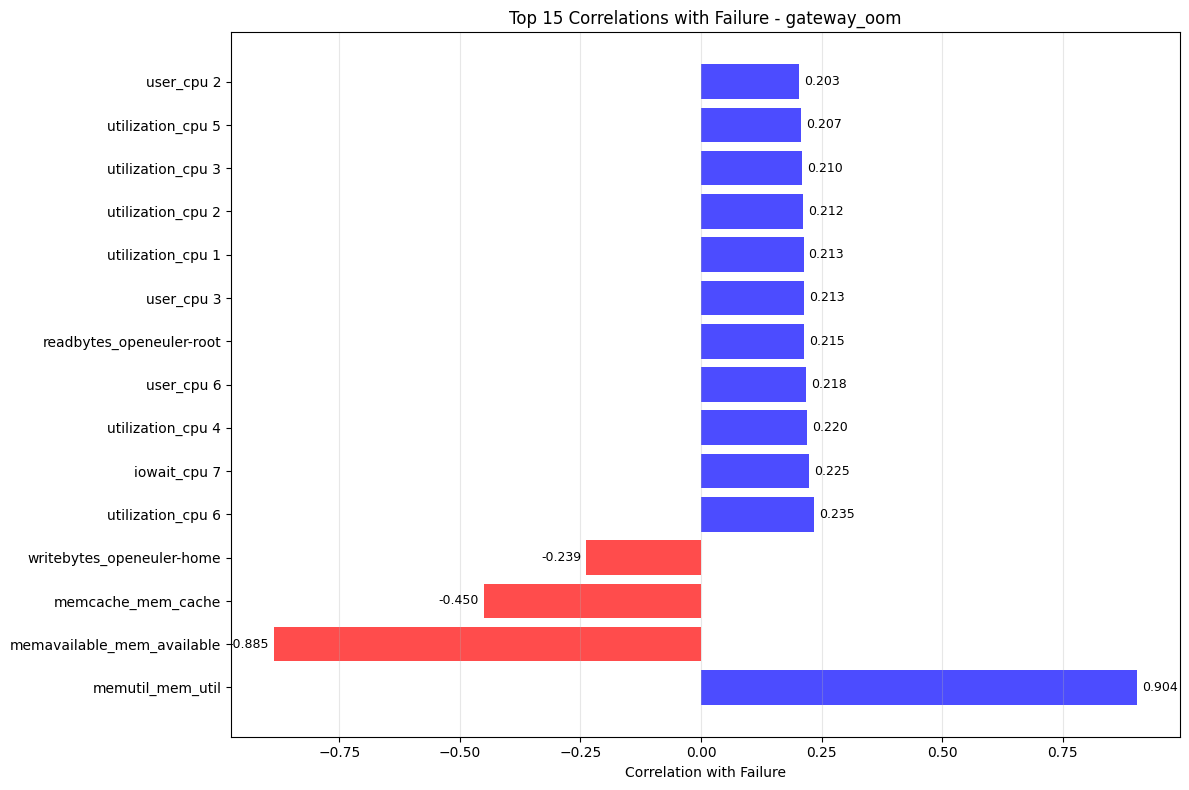

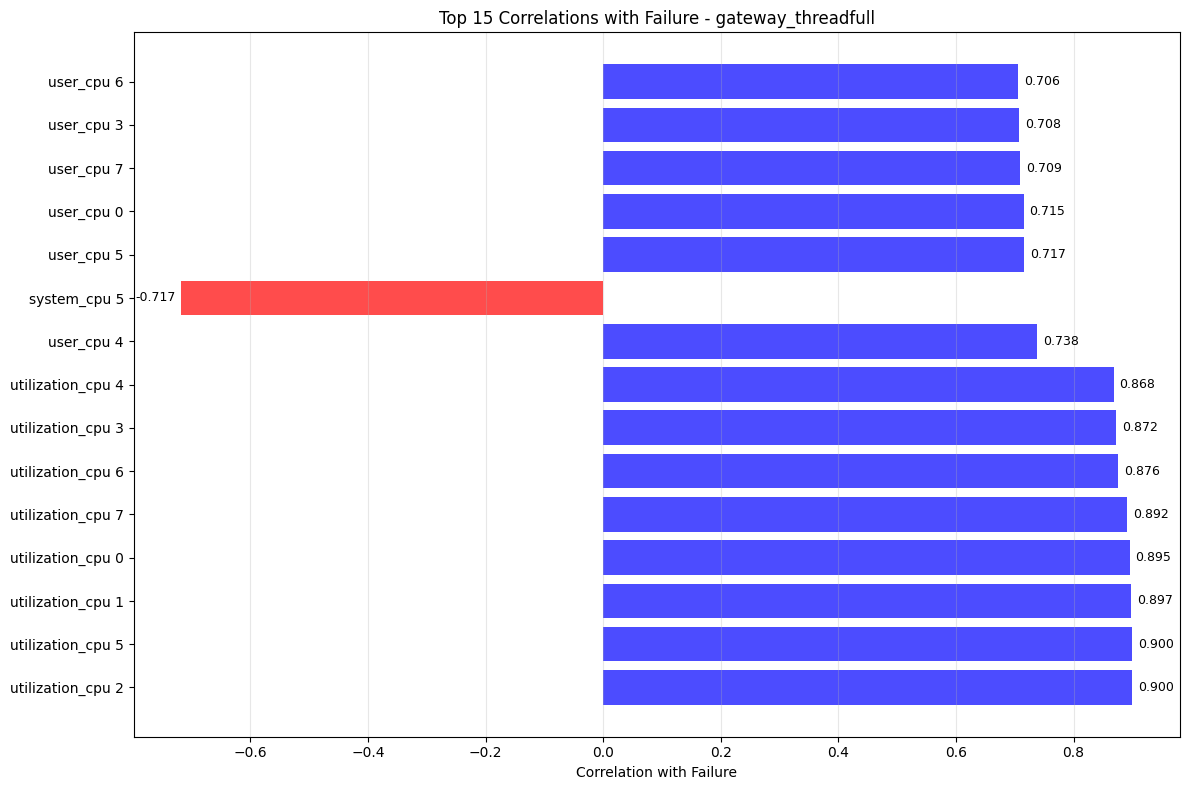

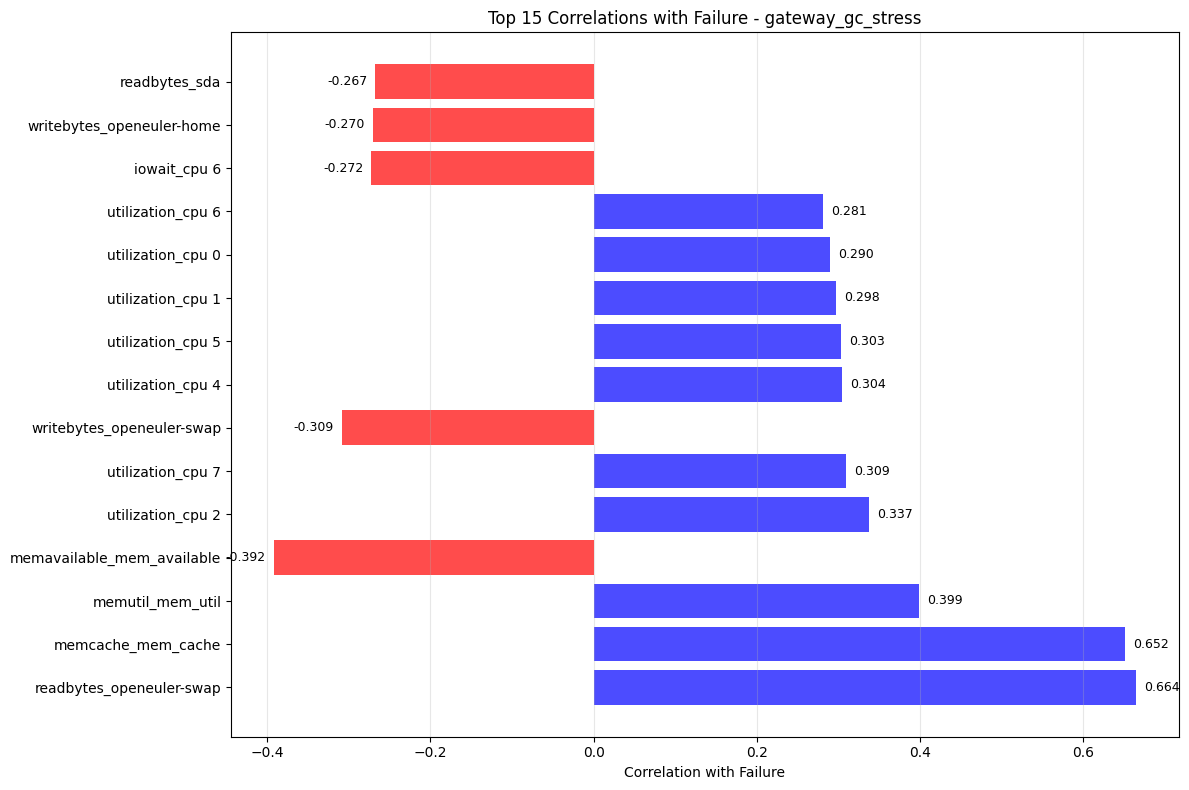

In [31]:
def add_failure_feature(df, time_col='minutes'):
    """Add failure feature based on time window (30-80 minutes)"""
    df = df.copy()
    
    if time_col not in df.columns:
        raise ValueError(f"Time column '{time_col}' not found")
    
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df['Failure'] = 0
    df.loc[(df[time_col] >= 30) & (df[time_col] < 80), 'Failure'] = 1
    
    return df

def add_failure_to_cleaned_datasets(cleaned_datasets):
    """Add failure labels to cleaned datasets permanently"""
    updated_datasets = {}
    
    for name, df in cleaned_datasets.items():
        df_copy = df.copy()
        
        if 'baseline' in name.lower():
            df_copy['Failure'] = 0
        else:
            df_copy = add_failure_feature(df_copy)
        
        updated_datasets[name] = df_copy
    
    return updated_datasets

def failure_correlations(df, target_col='Failure', min_variance=1e-10):
    """Calculate correlations with failure target"""
    if target_col not in df.columns:
        return None
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    if target_col not in numeric_df.columns:
        return None
    
    variance_filter = numeric_df.var() > min_variance
    filtered_df = numeric_df.loc[:, variance_filter]
    
    correlations = filtered_df.corr()[target_col].drop(target_col)
    correlations = correlations.dropna()
    
    correlations_abs = correlations.abs().sort_values(ascending=False)
    
    return correlations_abs

def plot_failure_correlations(df, target_col='Failure', top_n=15, dataset_name="Dataset"):
    """Plot correlation with failure target"""
    correlations = failure_correlations(df, target_col)
    
    if correlations is None or len(correlations) == 0:
        return
    
    top_correlations = correlations.head(top_n)
    original_corr = df.select_dtypes(include=[np.number]).corr()[target_col]
    top_correlations_signed = original_corr[top_correlations.index]
    
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'blue' for x in top_correlations_signed]
    bars = plt.barh(range(len(top_correlations_signed)), top_correlations_signed.values, color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_correlations_signed)), top_correlations_signed.index, rotation=0)
    plt.xlabel('Correlation with Failure')
    plt.title(f'Top {top_n} Correlations with Failure - {dataset_name}')
    plt.grid(axis='x', alpha=0.3)
    
    for i, (bar, val) in enumerate(zip(bars, top_correlations_signed.values)):
        plt.text(val + (0.01 if val >= 0 else -0.01), i, f'{val:.3f}', 
                va='center', ha='left' if val >= 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def analyze_constant_features_in_correlations(all_correlations):
    """Analyze which features appear consistently across datasets"""
    if not all_correlations:
        return {}
    
    feature_counts = {}
    feature_values = {}
    
    for dataset_name, correlations in all_correlations.items():
        for feature, corr_val in correlations.items():
            if feature not in feature_counts:
                feature_counts[feature] = 0
                feature_values[feature] = []
            feature_counts[feature] += 1
            feature_values[feature].append(corr_val)
    
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    
    analysis_results = {}
    for feature, count in sorted_features[:20]:
        values = feature_values[feature]
        avg_corr = np.mean(values)
        std_corr = np.std(values)
        
        analysis_results[feature] = {
            'dataset_count': count,
            'avg_correlation': avg_corr,
            'std_correlation': std_corr,
            'values': values
        }
    
    return analysis_results

def analyze_all_datasets_with_failure(cleaned_datasets_with_failure, target_col='Failure', top_n=15):
    """Analyze correlations for all datasets with failure feature"""
    all_correlations = {}
    
    for dataset_name, df in cleaned_datasets_with_failure.items():
        corr_df = failure_correlations(df, target_col)
        if corr_df is not None and len(corr_df) > 0:
            all_correlations[dataset_name] = corr_df
            plot_failure_correlations(df, target_col, top_n, dataset_name)
    
    return all_correlations

def run_failure_analysis_permanent_cleaned(cleaned_datasets):
    """Run failure analysis with permanently added Failure columns on cleaned datasets"""
    
    global cleaned_datasets_with_failure
    cleaned_datasets_with_failure = add_failure_to_cleaned_datasets(cleaned_datasets)
    
    df_all_cleaned_copy = pd.concat(cleaned_datasets_with_failure.values(), ignore_index=True)
    
    datasets_to_analyze = {k: v for k, v in cleaned_datasets_with_failure.items() 
                          if 'baseline' not in k.lower()}
    
    all_correlations = analyze_all_datasets_with_failure(datasets_to_analyze)
    
    constant_analysis = analyze_constant_features_in_correlations(all_correlations)
    
    return all_correlations, constant_analysis, cleaned_datasets_with_failure, df_all_cleaned_copy


all_correlations, constant_analysis, cleaned_datasets_with_failure, df_all_cleaned = run_failure_analysis_permanent_cleaned(cleaned_datasets)
    

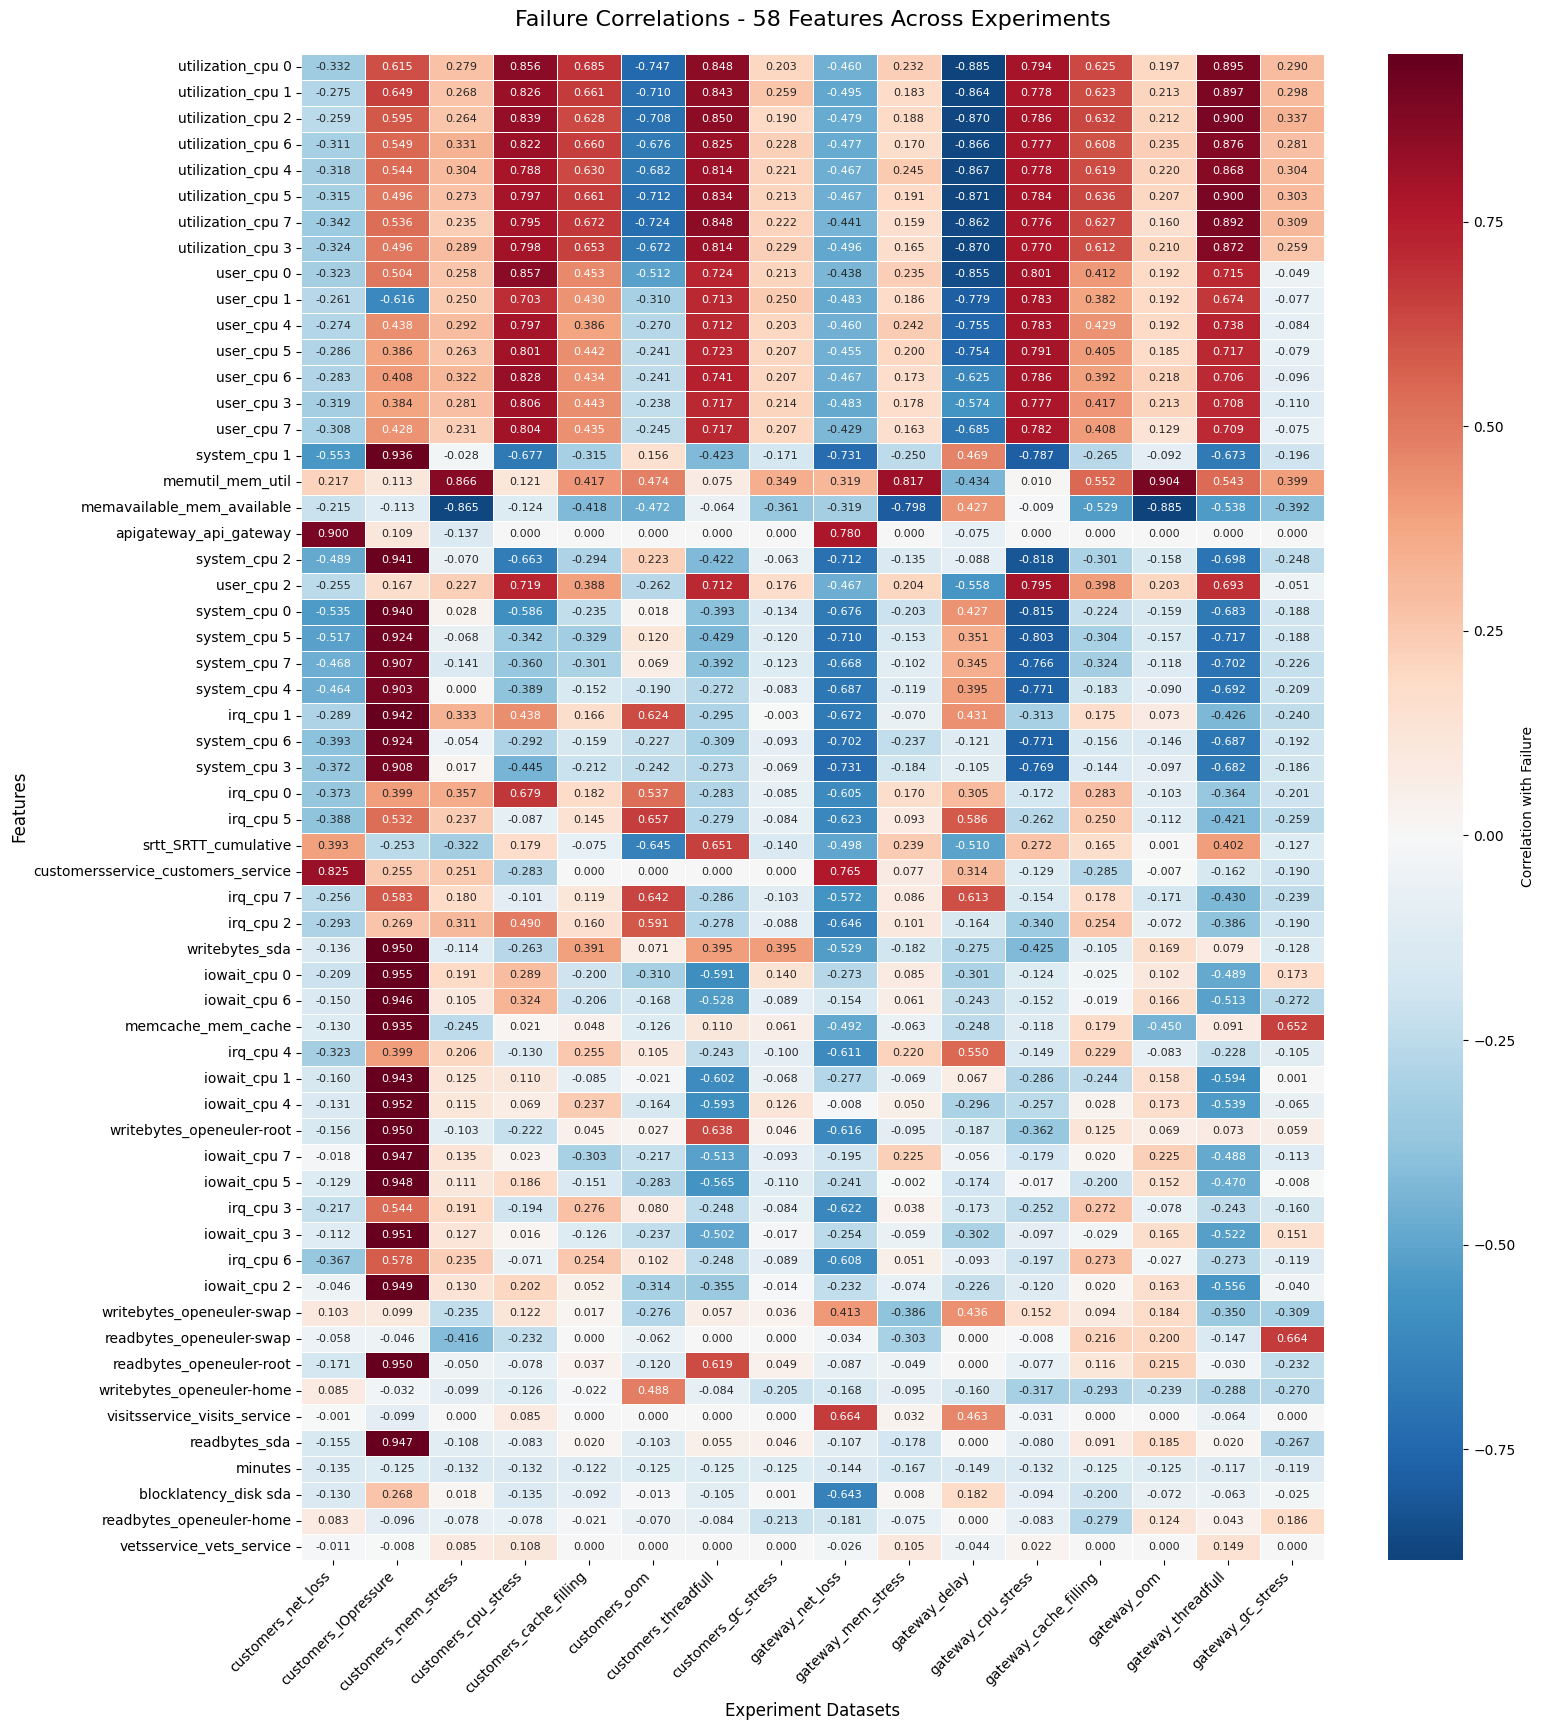

In [32]:
def create_heatmap(cleaned_datasets_with_failure, min_features=10, max_features=100):
    """Create complete failure correlation heatmap excluding baseline datasets"""
    
    # Filter out baseline datasets
    non_baseline_datasets = {k: v for k, v in cleaned_datasets_with_failure.items() 
                            if 'baseline' not in k.lower()}
    
    # Calculate correlations for all non-baseline datasets
    all_correlations_complete = {}
    all_features_set = set()
    
    for dataset_name, df in non_baseline_datasets.items():
        if 'Failure' not in df.columns:
            continue
        
        numeric_df = df.select_dtypes(include=[np.number])
        if 'Failure' not in numeric_df.columns:
            continue
        
        corr_matrix = numeric_df.corr()
        failure_correlations = corr_matrix['Failure'].drop('Failure')
        failure_correlations = failure_correlations.dropna()
        
        # Filter features with minimum variance
        variance_filter = numeric_df.drop('Failure', axis=1).var() > 1e-10
        valid_features = variance_filter[variance_filter].index
        failure_correlations = failure_correlations[failure_correlations.index.isin(valid_features)]
        
        all_correlations_complete[dataset_name] = failure_correlations
        all_features_set.update(failure_correlations.index)
    
    # Select most relevant features
    feature_importance = {}
    for dataset_name, correlations in all_correlations_complete.items():
        for feature, corr_val in correlations.items():
            if feature not in feature_importance:
                feature_importance[feature] = []
            feature_importance[feature].append(abs(corr_val))
    
    avg_importance = {}
    for feature, values in feature_importance.items():
        if len(values) >= 2:
            avg_importance[feature] = np.mean(values)
    
    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    num_features = min(max_features, max(min_features, len(sorted_features)))
    selected_features = [feature for feature, _ in sorted_features[:num_features]]
    
    # Create heatmap matrix
    dataset_names = list(all_correlations_complete.keys())
    heatmap_matrix = []
    
    for feature in selected_features:
        row = []
        for dataset_name in dataset_names:
            correlations = all_correlations_complete[dataset_name]
            if feature in correlations.index:
                corr_value = correlations[feature]
                row.append(corr_value)
            else:
                row.append(0.0)
        heatmap_matrix.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_matrix, 
                             index=selected_features, 
                             columns=dataset_names)
    
    plt.figure(figsize=(16, max(12, len(selected_features) * 0.3)))
    
    sns.heatmap(heatmap_df, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                center=0,
                cbar_kws={'label': 'Correlation with Failure'},
                linewidths=0.5,
                annot_kws={'size': 8})
    
    plt.title(f'Failure Correlations - {len(selected_features)} Features Across Experiments', 
              fontsize=16, pad=20)
    plt.xlabel('Experiment Datasets', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return heatmap_df
    
complete_heatmap = create_heatmap(cleaned_datasets_with_failure, 
                                                    min_features=30, max_features=60)


## check failure target settings

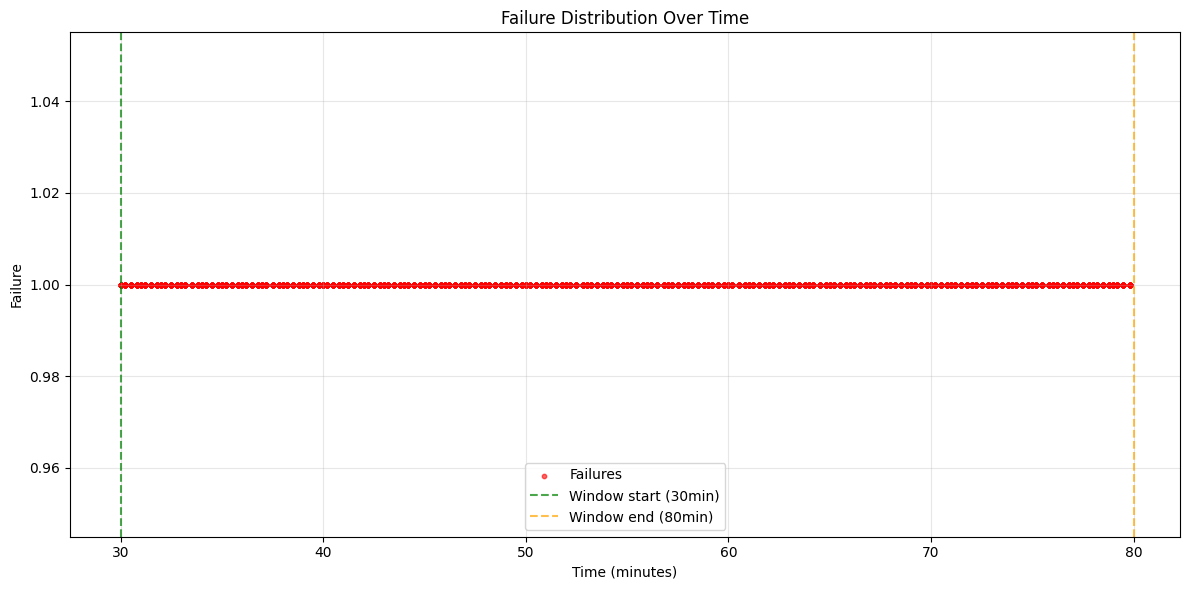

In [33]:
def check_failures_in_combined_dataset(df_combined):
    """Check failure distribution in combined dataset"""
    
    if 'Failure' not in df_combined.columns:
        return None
    
    failure_counts = df_combined['Failure'].value_counts().sort_index()
    
    # Check by source/experiment
    if 'source' in df_combined.columns:
        source_failures = df_combined.groupby('source')['Failure'].agg(['count', 'sum', 'mean'])
        source_failures['failure_pct'] = source_failures['mean'] * 100
        source_failures = source_failures.round(1)
    
    # Time window validation
    if 'minutes' in df_combined.columns and 'source' in df_combined.columns:
        non_baseline = ~df_combined['source'].str.contains('baseline', case=False, na=False)
        non_baseline_data = df_combined[non_baseline]
        non_baseline_window = non_baseline_data[
            (non_baseline_data['minutes'] >= 30) & (non_baseline_data['minutes'] < 80)
        ]
        
        expected_failures = len(non_baseline_window)
        actual_failures = non_baseline_window['Failure'].sum()
        
        validation_passed = expected_failures == actual_failures
    else:
        validation_passed = None
    
    return {
        'failure_counts': failure_counts,
        'source_failures': source_failures if 'source' in df_combined.columns else None,
        'validation_passed': validation_passed
    }

def plot_failure_timeline(df_combined):
    """Plot failures over time"""
    
    if 'minutes' not in df_combined.columns or 'Failure' not in df_combined.columns:
        return
    
    plt.figure(figsize=(12, 6))
    
    failure_data = df_combined[df_combined['Failure'] == 1]
    if len(failure_data) > 0:
        plt.scatter(failure_data['minutes'], [1] * len(failure_data), 
                   alpha=0.6, s=10, color='red', label='Failures')
    
    plt.axvline(x=30, color='green', linestyle='--', alpha=0.7, label='Window start (30min)')
    plt.axvline(x=80, color='orange', linestyle='--', alpha=0.7, label='Window end (80min)')
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('Failure')
    plt.title('Failure Distribution Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def export_combined_dataset_to_csv(df, filename="df_all_cleaned_complete.csv"):
    """Export complete combined dataset to CSV"""
    
    df.to_csv(filename, index=False)
    return filename

def export_with_analysis(df, base_filename="df_all_cleaned"):
    """Export dataset with additional analysis files"""
    
    files_created = {}
    
    # Main dataset
    main_file = f"{base_filename}_complete.csv"
    df.to_csv(main_file, index=False)
    files_created['complete'] = main_file
    
    # Key columns only
    key_columns = ['minutes', 'source', 'service', 'Failure']
    available_key_columns = [col for col in key_columns if col in df.columns]
    
    if available_key_columns:
        key_file = f"{base_filename}_key_info.csv"
        df[available_key_columns].to_csv(key_file, index=False)
        files_created['key_info'] = key_file
    
    # Failures only
    if 'Failure' in df.columns:
        failure_file = f"{base_filename}_failures_only.csv"
        failure_data = df[df['Failure'] == 1]
        failure_data.to_csv(failure_file, index=False)
        files_created['failures_only'] = failure_file
    
    # Summary by experiment
    if 'source' in df.columns:
        summary_data = []
        for source in df['source'].unique():
            source_data = df[df['source'] == source]
            
            summary_row = {
                'experiment': source,
                'total_rows': len(source_data),
                'failures': source_data['Failure'].sum() if 'Failure' in source_data.columns else 0,
                'failure_rate_pct': (source_data['Failure'].mean() * 100) if 'Failure' in source_data.columns else 0,
                'min_time': source_data['minutes'].min() if 'minutes' in source_data.columns else None,
                'max_time': source_data['minutes'].max() if 'minutes' in source_data.columns else None,
                'duration_minutes': (source_data['minutes'].max() - source_data['minutes'].min()) if 'minutes' in source_data.columns else None,
                'is_baseline': 'baseline' in source.lower()
            }
            summary_data.append(summary_row)
        
        summary_df = pd.DataFrame(summary_data)
        summary_file = f"{base_filename}_summary.csv"
        summary_df.to_csv(summary_file, index=False)
        files_created['summary'] = summary_file
    
    return files_created

# Execute functions
if 'df_all_cleaned' in globals():
    failure_check = check_failures_in_combined_dataset(df_all_cleaned)
    plot_failure_timeline(df_all_cleaned)
    
    filename = export_combined_dataset_to_csv(df_all_cleaned)
    files_created = export_with_analysis(df_all_cleaned)
    
elif 'cleaned_datasets_with_failure' in globals():
    df_combined = pd.concat(cleaned_datasets_with_failure.values(), ignore_index=True)
    failure_check = check_failures_in_combined_dataset(df_combined)
    plot_failure_timeline(df_combined)
    
    filename = export_combined_dataset_to_csv(df_combined)
    files_created = export_with_analysis(df_combined)

In [34]:
import pandas as pd
import numpy as np

def comprehensive_nan_analysis(df):
    """Comprehensive analysis of NaN values in the dataset"""
    
    print("🔍 COMPREHENSIVE NaN ANALYSIS")
    print("=" * 60)
    
    print(f"Dataset shape: {df.shape}")
    total_nan = df.isnull().sum().sum()
    total_cells = df.shape[0] * df.shape[1]
    nan_percentage = (total_nan / total_cells) * 100
    
    print(f"Total NaN values: {total_nan:,}")
    print(f"Total cells: {total_cells:,}")
    print(f"NaN percentage: {nan_percentage:.2f}%")
    
    # Find columns with NaN
    nan_columns = df.columns[df.isnull().any()].tolist()
    print(f"\nColumns with NaN: {len(nan_columns)}")
    
    if len(nan_columns) > 0:
        print("\nNaN breakdown by column:")
        nan_stats = []
        for col in nan_columns:
            nan_count = df[col].isnull().sum()
            nan_pct = (nan_count / len(df)) * 100
            nan_stats.append({
                'column': col,
                'nan_count': nan_count,
                'nan_percentage': nan_pct,
                'dtype': str(df[col].dtype)
            })
        
        nan_df = pd.DataFrame(nan_stats).sort_values('nan_count', ascending=False)
        print(nan_df.to_string(index=False))
        
        # Show sample of NaN locations
        print(f"\n📍 Sample NaN locations (first 10 rows):")
        print("-" * 40)
        
        # Show head with NaN columns only
        if len(nan_columns) <= 10:  # If few columns, show all
            nan_sample = df[nan_columns].head(10)
        else:  # If many columns, show first 5
            nan_sample = df[nan_columns[:5]].head(10)
        
        print(nan_sample.to_string())
        
        # Check if NaN values are clustered in specific rows
        print(f"\n📊 NaN distribution analysis:")
        print("-" * 40)
        
        # Count NaN per row
        nan_per_row = df.isnull().sum(axis=1)
        print(f"Rows with 0 NaN: {(nan_per_row == 0).sum():,}")
        print(f"Rows with 1+ NaN: {(nan_per_row > 0).sum():,}")
        print(f"Max NaN in single row: {nan_per_row.max()}")
        
        if nan_per_row.max() > 0:
            print(f"\nNaN per row distribution:")
            nan_row_dist = nan_per_row.value_counts().sort_index()
            for nan_count, row_count in nan_row_dist.head(10).items():
                print(f"  {nan_count} NaN: {row_count:,} rows")
        
        # Check if NaN values follow patterns (e.g., by source/experiment)
        if 'source' in df.columns:
            print(f"\n📋 NaN by experiment/source:")
            print("-" * 40)
            for source in df['source'].unique():
                source_data = df[df['source'] == source]
                source_nan = source_data.isnull().sum().sum()
                source_total = source_data.shape[0] * source_data.shape[1]
                source_pct = (source_nan / source_total) * 100 if source_total > 0 else 0
                print(f"  {source}: {source_nan:,} NaN ({source_pct:.1f}%)")
    
    return nan_columns

def show_nan_samples(df, nan_columns, n_samples=5):
    """Show specific samples where NaN values occur"""
    
    print(f"\n🔎 DETAILED NaN SAMPLES")
    print("=" * 60)
    
    for col in nan_columns[:3]:  # Show first 3 NaN columns
        print(f"\nColumn: {col}")
        print("-" * 30)
        
        # Find rows with NaN in this column
        nan_rows = df[df[col].isnull()]
        
        if len(nan_rows) > 0:
            print(f"NaN count: {len(nan_rows)}")
            print(f"Sample rows with NaN:")
            
            # Show key columns + the NaN column
            key_cols = ['minutes', 'source', 'service'] if all(c in df.columns for c in ['minutes', 'source', 'service']) else []
            display_cols = key_cols + [col]
            available_cols = [c for c in display_cols if c in df.columns]
            
            sample_data = nan_rows[available_cols].head(n_samples)
            print(sample_data.to_string())
            
            # Show some non-NaN values for comparison
            non_nan_rows = df[df[col].notna()]
            if len(non_nan_rows) > 0:
                print(f"\nComparison - non-NaN values:")
                sample_non_nan = non_nan_rows[available_cols].head(3)
                print(sample_non_nan.to_string())

def check_data_integrity(df):
    """Check overall data integrity"""
    
    print(f"\n🔧 DATA INTEGRITY CHECK")
    print("=" * 60)
    
    # Check data types
    print("Data types distribution:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_count = 0
    inf_cols = []
    
    for col in numeric_cols:
        col_inf = np.isinf(df[col]).sum()
        if col_inf > 0:
            inf_count += col_inf
            inf_cols.append(col)
    
    if inf_count > 0:
        print(f"\n⚠️  Infinite values found: {inf_count}")
        print(f"Columns with infinite values: {inf_cols[:5]}...")
    else:
        print(f"\n✅ No infinite values found")
    
    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    print(f"Duplicate rows: {duplicate_count}")
    
    # Check for constant columns
    const_cols = []
    for col in df.columns:
        if df[col].nunique() <= 1:
            const_cols.append(col)
    
    if len(const_cols) > 0:
        print(f"\n⚠️  Constant columns found: {len(const_cols)}")
        print(f"Constant columns: {const_cols}")
    else:
        print(f"\n✅ No constant columns found")

# Execute comprehensive analysis
if 'df_all_cleaned' in globals():
    print("Analyzing df_all_cleaned...")
    
    # Comprehensive NaN analysis
    nan_columns = comprehensive_nan_analysis(df_all_cleaned)
    
    # Show detailed samples
    if len(nan_columns) > 0:
        show_nan_samples(df_all_cleaned, nan_columns)
    
    # Check overall integrity
    check_data_integrity(df_all_cleaned)
    
    # Show head with focus on problematic columns
    print(f"\n📋 HEAD OF DATASET (focusing on NaN columns)")
    print("=" * 60)
    
    if len(nan_columns) > 0:
        # Show key columns + first few NaN columns
        key_columns = ['minutes', 'source', 'service', 'Failure']
        display_columns = key_columns + nan_columns[:3]
        available_display = [col for col in display_columns if col in df_all_cleaned.columns]
        
        print("Columns displayed:", available_display)
        print(df_all_cleaned[available_display].head(15).to_string())
    else:
        print("No NaN columns found - showing regular head:")
        print(df_all_cleaned.head().to_string())

else:
    print("❌ df_all_cleaned not found!")
    
    # Check what datasets are available
    available_dfs = []
    for var_name in globals():
        if 'df' in var_name.lower() and isinstance(globals()[var_name], pd.DataFrame):
            available_dfs.append(var_name)
    
    print(f"Available DataFrames: {available_dfs}")

Analyzing df_all_cleaned...
🔍 COMPREHENSIVE NaN ANALYSIS
Dataset shape: (8711, 71)
Total NaN values: 2,916
Total cells: 618,481
NaN percentage: 0.47%

Columns with NaN: 3

NaN breakdown by column:
                    column  nan_count  nan_percentage   dtype
memavailable_mem_available        972       11.158306 float64
        memcache_mem_cache        972       11.158306 float64
          memutil_mem_util        972       11.158306 float64

📍 Sample NaN locations (first 10 rows):
----------------------------------------
   memavailable_mem_available  memcache_mem_cache  memutil_mem_util
0                  16765196.0           3384604.0              32.1
1                  16765196.0           3384604.0              32.1
2                  16765196.0           3384604.0              32.1
3                  17402496.0           3388574.0              27.4
4                  17917877.0           3387245.0              26.5
5                  17996534.0           3387245.0              26

## feature engineering

🚀 Starting feature engineering and selection pipeline...

--- DEBUG: Initial Data ---
Shape: (8711, 71)
⚠️  NaN values found: 2916
   Columns with NaN: ['memavailable_mem_available', 'memcache_mem_cache', 'memutil_mem_util']...
✅ No infinite values
Data types: {dtype('float64'): 68, dtype('O'): 2, dtype('int64'): 1}
Dropped columns: ['source', 'service']

--- DEBUG: After Base Preparation ---
Shape: (8711, 69)
⚠️  NaN values found: 2916
   Columns with NaN: ['memavailable_mem_available', 'memcache_mem_cache', 'memutil_mem_util']...
✅ No infinite values
Data types: {dtype('float64'): 68, dtype('int64'): 1}
✅ Base features prepared: (8711, 69)

Starting feature engineering with 69 columns
✅ Created time-based features
✅ Created CPU utilization features from 10 columns
✅ Created User CPU features from 10 columns
✅ Created System CPU features from 10 columns
✅ Created IRQ CPU features from 10 columns
✅ Created Network features from 1 columns
✅ Created statistical features from 73 base metr

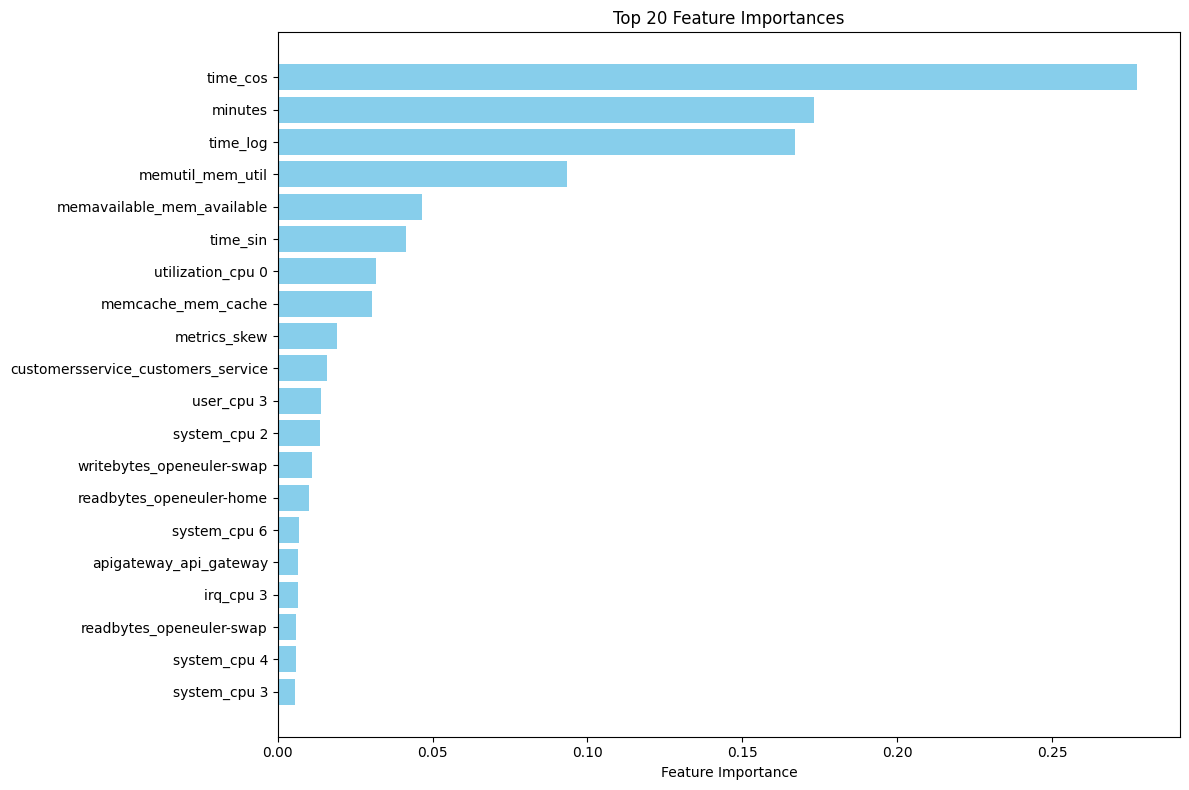


🔄 Preparing train/test split...
   Target distribution: {0: 5511, 1: 3200}
✅ Train/test split complete
   Training: (6968, 25), Test: (1743, 25)

🎉 PIPELINE SUCCESS!

Feature Engineering Summary:
  original_features: 68
  engineered_features: 88
  after_correlation_filter: 39
  after_statistical_selection: 29
  final_features: 25

Train/Test Split:
  Training samples: 6968
  Test samples: 1743
  Features: 25

📦 Available variables:
  • final_dataset: (8711, 26)
  • feature_importance: Top features ranked
  • X_train, X_test: Scaled features
  • y_train, y_test: Target labels
  • scaler: For new data preprocessing


In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def check_data_quality(df, step_name):
    """Debug function to check data quality"""
    print(f"\n--- DEBUG: {step_name} ---")
    print(f"Shape: {df.shape}")
    
    # Check for NaN
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        print(f"⚠️  NaN values found: {nan_count}")
        nan_cols = df.columns[df.isnull().any()].tolist()
        print(f"   Columns with NaN: {nan_cols[:5]}...")  # Show first 5
    else:
        print("✅ No NaN values")
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_count = 0
    for col in numeric_cols:
        if np.isinf(df[col]).any():
            inf_count += np.isinf(df[col]).sum()
    
    if inf_count > 0:
        print(f"⚠️  Infinite values found: {inf_count}")
    else:
        print("✅ No infinite values")
    
    print(f"Data types: {df.dtypes.value_counts().to_dict()}")

def prepare_base_features(df):
    """Prepare base features for ML"""
    
    df_ml = df.copy()
    check_data_quality(df_ml, "Initial Data")
    
    # Remove non-predictive columns
    columns_to_drop = ['source', 'service']
    existing_drops = [col for col in columns_to_drop if col in df_ml.columns]
    if existing_drops:
        df_ml = df_ml.drop(columns=existing_drops)
        print(f"Dropped columns: {existing_drops}")
    
    # Handle any remaining categorical columns
    categorical_cols = df_ml.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"Dropping categorical columns: {categorical_cols.tolist()}")
        df_ml = df_ml.drop(columns=categorical_cols)
    
    # Ensure target column exists
    if 'Failure' not in df_ml.columns:
        raise ValueError("Failure column not found")
    
    check_data_quality(df_ml, "After Base Preparation")
    return df_ml

def create_engineered_features(df_ml):
    """Create new engineered features"""
    
    df_eng = df_ml.copy()
    print(f"\nStarting feature engineering with {df_eng.shape[1]} columns")
    
    # Time-based features
    if 'minutes' in df_eng.columns:
        df_eng['time_squared'] = df_eng['minutes'] ** 2
        df_eng['time_log'] = np.log1p(df_eng['minutes'])
        df_eng['time_sin'] = np.sin(2 * np.pi * df_eng['minutes'] / 120)
        df_eng['time_cos'] = np.cos(2 * np.pi * df_eng['minutes'] / 120)
        print("✅ Created time-based features")
    
    # CPU utilization aggregations
    cpu_util_cols = [col for col in df_eng.columns if 'utilization_cpu' in col]
    if len(cpu_util_cols) > 1:
        df_eng['cpu_util_mean'] = df_eng[cpu_util_cols].mean(axis=1)
        df_eng['cpu_util_max'] = df_eng[cpu_util_cols].max(axis=1)
        df_eng['cpu_util_std'] = df_eng[cpu_util_cols].std(axis=1, ddof=0)
        df_eng['cpu_util_range'] = df_eng[cpu_util_cols].max(axis=1) - df_eng[cpu_util_cols].min(axis=1)
        print(f"✅ Created CPU utilization features from {len(cpu_util_cols)} columns")
    
    # User CPU aggregations
    user_cpu_cols = [col for col in df_eng.columns if 'user_cpu' in col]
    if len(user_cpu_cols) > 1:
        df_eng['user_cpu_mean'] = df_eng[user_cpu_cols].mean(axis=1)
        df_eng['user_cpu_max'] = df_eng[user_cpu_cols].max(axis=1)
        df_eng['user_cpu_std'] = df_eng[user_cpu_cols].std(axis=1, ddof=0)
        print(f"✅ Created User CPU features from {len(user_cpu_cols)} columns")
    
    # System CPU aggregations
    system_cpu_cols = [col for col in df_eng.columns if 'system_cpu' in col]
    if len(system_cpu_cols) > 1:
        df_eng['system_cpu_mean'] = df_eng[system_cpu_cols].mean(axis=1)
        df_eng['system_cpu_max'] = df_eng[system_cpu_cols].max(axis=1)
        df_eng['system_cpu_std'] = df_eng[system_cpu_cols].std(axis=1, ddof=0)
        print(f"✅ Created System CPU features from {len(system_cpu_cols)} columns")
    
    # IRQ CPU aggregations
    irq_cpu_cols = [col for col in df_eng.columns if 'irq_cpu' in col]
    if len(irq_cpu_cols) > 1:
        df_eng['irq_cpu_mean'] = df_eng[irq_cpu_cols].mean(axis=1)
        df_eng['irq_cpu_sum'] = df_eng[irq_cpu_cols].sum(axis=1)
        print(f"✅ Created IRQ CPU features from {len(irq_cpu_cols)} columns")
    
    # Memory features
    memory_cols = [col for col in df_eng.columns if 'memory' in col.lower()]
    if len(memory_cols) > 0:
        df_eng['memory_pressure_ratio'] = df_eng[memory_cols].sum(axis=1)
        print(f"✅ Created Memory features from {len(memory_cols)} columns")
    
    # Network features
    network_cols = [col for col in df_eng.columns if any(net in col.lower() for net in ['network', 'tcp', 'udp', 'srtt'])]
    if len(network_cols) > 0:
        df_eng['network_activity'] = df_eng[network_cols].sum(axis=1)
        print(f"✅ Created Network features from {len(network_cols)} columns")
    
    # Resource ratios
    if 'cpu_util_mean' in df_eng.columns and 'memory_pressure_ratio' in df_eng.columns:
        df_eng['cpu_memory_ratio'] = df_eng['cpu_util_mean'] / (df_eng['memory_pressure_ratio'] + 1e-8)
        print("✅ Created resource ratio features")
    
    # Statistical features across all metrics
    numeric_cols = df_eng.select_dtypes(include=[np.number]).columns
    exclude_cols = ['Failure'] + [col for col in numeric_cols if any(suffix in col for suffix in ['_mean', '_max', '_std', '_sum', '_ratio', '_range'])]
    base_metrics = [col for col in numeric_cols if col not in exclude_cols]
    
    if len(base_metrics) > 1:
        df_eng['metrics_mean'] = df_eng[base_metrics].mean(axis=1)
        df_eng['metrics_std'] = df_eng[base_metrics].std(axis=1, ddof=0)
        df_eng['metrics_skew'] = df_eng[base_metrics].skew(axis=1)
        print(f"✅ Created statistical features from {len(base_metrics)} base metrics")
    
    # Clean up any issues created during engineering
    check_data_quality(df_eng, "Before Cleanup")
    
    # Fill NaN values that might have been created
    nan_before = df_eng.isnull().sum().sum()
    if nan_before > 0:
        df_eng = df_eng.fillna(0)
        print(f"🔧 Filled {nan_before} NaN values with 0")
    
    # Replace infinite values
    inf_before = np.isinf(df_eng.select_dtypes(include=[np.number])).sum().sum()
    if inf_before > 0:
        df_eng = df_eng.replace([np.inf, -np.inf], 0)
        print(f"🔧 Replaced {inf_before} infinite values with 0")
    
    check_data_quality(df_eng, "After Feature Engineering")
    return df_eng

def correlation_feature_selection(df_eng, target_col='Failure', correlation_threshold=0.95):
    """Remove highly correlated features"""
    
    X = df_eng.drop(columns=[target_col])
    y = df_eng[target_col]
    
    print(f"\n🔍 Correlation analysis on {X.shape[1]} features")
    
    # Calculate correlation matrix
    corr_matrix = X.corr().abs()
    
    # Find highly correlated pairs
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
    
    if len(to_drop) > 0:
        print(f"🗑️  Dropping {len(to_drop)} highly correlated features (threshold: {correlation_threshold})")
        X_reduced = X.drop(columns=to_drop)
    else:
        print(f"✅ No highly correlated features found")
        X_reduced = X
    
    df_reduced = pd.concat([X_reduced, y], axis=1)
    check_data_quality(df_reduced, "After Correlation Filter")
    
    return df_reduced, to_drop

def statistical_feature_selection(df_reduced, target_col='Failure', k=50):
    """Select top k features using statistical tests"""
    
    X = df_reduced.drop(columns=[target_col])
    y = df_reduced[target_col]
    
    print(f"\n📊 Statistical feature selection from {X.shape[1]} features")
    
    # Final safety checks
    nan_count = X.isnull().sum().sum()
    if nan_count > 0:
        print(f"⚠️  Found {nan_count} NaN values, filling with 0")
        X = X.fillna(0)
    
    inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
    if inf_count > 0:
        print(f"⚠️  Found {inf_count} infinite values, replacing with 0")
        X = X.replace([np.inf, -np.inf], 0)
    
    # Check for constant features
    constant_features = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_features.append(col)
    
    if len(constant_features) > 0:
        print(f"🗑️  Removing {len(constant_features)} constant features")
        X = X.drop(columns=constant_features)
    
    # Ensure we don't select more features than available
    k_actual = min(k, X.shape[1])
    print(f"📋 Selecting {k_actual} features using f_classif")
    
    # SelectKBest with f_classif
    selector = SelectKBest(score_func=f_classif, k=k_actual)
    
    try:
        X_selected = selector.fit_transform(X, y)
        
        # Get selected feature names
        selected_features = X.columns[selector.get_support()].tolist()
        
        # Create new dataframe with selected features
        df_selected = pd.DataFrame(X_selected, columns=selected_features)
        df_selected[target_col] = y.values
        
        # Get feature scores
        feature_scores = pd.DataFrame({
            'feature': X.columns,
            'score': selector.scores_,
            'selected': selector.get_support()
        }).sort_values('score', ascending=False)
        
        print(f"✅ Successfully selected {len(selected_features)} features")
        check_data_quality(df_selected, "After Statistical Selection")
        
        return df_selected, feature_scores
        
    except Exception as e:
        print(f"❌ Error in statistical selection: {str(e)}")
        print(f"   X shape: {X.shape}, y shape: {y.shape}")
        print(f"   X dtypes: {X.dtypes.value_counts().to_dict()}")
        raise

def tree_based_feature_selection(df_selected, target_col='Failure', n_features=30):
    """Select features using Random Forest importance"""
    
    X = df_selected.drop(columns=[target_col])
    y = df_selected[target_col]
    
    n_features_actual = min(n_features, X.shape[1])
    print(f"\n🌳 Tree-based selection: selecting {n_features_actual} from {X.shape[1]} features")
    
    # Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top n features
    top_features = feature_importance.head(n_features_actual)['feature'].tolist()
    
    # Create final dataframe
    df_final = X[top_features].copy()
    df_final[target_col] = y.values
    
    print(f"✅ Final feature selection complete")
    check_data_quality(df_final, "Final Dataset")
    
    return df_final, feature_importance

def plot_feature_importance(feature_importance, top_n=20):
    """Plot feature importance"""
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def create_ml_dataset(df, target_col='Failure', final_features=25):
    """Complete feature engineering and selection pipeline"""
    
    print("🚀 Starting feature engineering and selection pipeline...")
    
    try:
        # Step 1: Prepare base features
        df_ml = prepare_base_features(df)
        print(f"✅ Base features prepared: {df_ml.shape}")
        
        # Step 2: Create engineered features
        df_eng = create_engineered_features(df_ml)
        print(f"✅ After feature engineering: {df_eng.shape}")
        
        # Step 3: Remove highly correlated features
        df_reduced, dropped_corr = correlation_feature_selection(df_eng, target_col)
        print(f"✅ After correlation filtering: {df_reduced.shape}")
        
        # Step 4: Statistical feature selection
        df_selected, feature_scores = statistical_feature_selection(df_reduced, target_col, k=50)
        print(f"✅ After statistical selection: {df_selected.shape}")
        
        # Step 5: Tree-based feature selection
        df_final, feature_importance = tree_based_feature_selection(df_selected, target_col, n_features=final_features)
        print(f"✅ Final dataset: {df_final.shape}")
        
        # Plot feature importance
        plot_feature_importance(feature_importance, top_n=min(20, len(feature_importance)))
        
        return {
            'final_dataset': df_final,
            'feature_importance': feature_importance,
            'feature_scores': feature_scores,
            'dropped_correlated': dropped_corr,
            'engineering_stats': {
                'original_features': df_ml.shape[1] - 1,
                'engineered_features': df_eng.shape[1] - 1,
                'after_correlation_filter': df_reduced.shape[1] - 1,
                'after_statistical_selection': df_selected.shape[1] - 1,
                'final_features': df_final.shape[1] - 1
            }
        }
        
    except Exception as e:
        print(f"❌ Pipeline failed: {str(e)}")
        raise

def prepare_train_test_split(df_final, target_col='Failure', test_size=0.2, random_state=42):
    """Prepare train/test split with scaling"""
    
    X = df_final.drop(columns=[target_col])
    y = df_final[target_col]
    
    print(f"\n🔄 Preparing train/test split...")
    print(f"   Target distribution: {y.value_counts().to_dict()}")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    print(f"✅ Train/test split complete")
    print(f"   Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }

# Execute feature engineering pipeline
if 'df_all_cleaned' in globals():
    
    try:
        # Create ML dataset
        ml_results = create_ml_dataset(df_all_cleaned, final_features=25)
        
        # Prepare train/test split
        train_test_data = prepare_train_test_split(ml_results['final_dataset'])
        
        print(f"\n🎉 PIPELINE SUCCESS!")
        print(f"\nFeature Engineering Summary:")
        for key, value in ml_results['engineering_stats'].items():
            print(f"  {key}: {value}")
        
        print(f"\nTrain/Test Split:")
        print(f"  Training samples: {len(train_test_data['X_train'])}")
        print(f"  Test samples: {len(train_test_data['X_test'])}")
        print(f"  Features: {len(train_test_data['feature_names'])}")
        
        # Available variables
        final_dataset = ml_results['final_dataset']
        feature_importance = ml_results['feature_importance']
        X_train = train_test_data['X_train']
        X_test = train_test_data['X_test']
        y_train = train_test_data['y_train']
        y_test = train_test_data['y_test']
        scaler = train_test_data['scaler']
        
        print(f"\n📦 Available variables:")
        print(f"  • final_dataset: {final_dataset.shape}")
        print(f"  • feature_importance: Top features ranked")
        print(f"  • X_train, X_test: Scaled features")
        print(f"  • y_train, y_test: Target labels")
        print(f"  • scaler: For new data preprocessing")
        
    except Exception as e:
        print(f"❌ Pipeline failed with error: {str(e)}")
        import traceback
        traceback.print_exc()
    
else:
    print("❌ df_all_cleaned not found!")

LSTM